# **Proyecto Predicción COVID**





**1.	Definición del problema real**

Uno de los mayores desafíos que el mundo ha enfrentado en los últimos tiempos ha sido la pandemia generada por el coronavirus (COVID-19). Desde los primeros reportes de infectados en diciembre de 2019, diferentes sectores han tenido una carrera contrarreloj para intentar anticiparse a los efectos que el síndrome de Corona Virus 2 (SARS-CoV-2) tiene sobre la sociedad. Estas necesidades de información y manejo eficiente de la misma no solamente tienen un interés médico, sino que debido a su impacto generalizado es fundamental para la emisión de políticas públicas y medidas de control a la población.
El 26 de febrero de 2020, fue reportado el primer caso de COVID-19 en Latinoamérica, donde hasta ese momento era la única región del mundo donde no había logrado alcanzar la pandemia. Esto presupone que los países de esta región contaron con una ventaja en términos de tiempo para prepararse a las medidas y controles a efectuarse frente a esta contingencia, así como aprendizaje del comportamiento que este virus tuvo en los primeros países que lo sufrieron.
El 6 de marzo de 2020, se confirmó el primer caso de COVID-19 en Colombia, entrando así en la fase de contención y dando inicio a la recolección de información derivada del comportamiento del virus en nuestro país. Esta información es la base para el entendimiento del comportamiento del virus y la proyección de comportamientos futuros que sirvan de soporte para la planeación de medidas de contingencia, disponibilidad de servicios de salud, generación de políticas económicas y sociales, entre otros.


**2.	Definición del problema de analítica.**

El pronóstico de número de casos confirmados, activos, recuperados o fallecidos, constituye un problema analítico al tratarse de un suceso en curso, cuyo comportamiento depende de una serie de fenómenos de los que no se encuentra información estructurada, y por esta razón se dificulta la evaluación de su incidencia en el fenómeno principal.

La población de áreas urbanas y ciudades corre el riesgo de contraer el virus, en este sentido se hace necesario, pronosticar el número de casos confirmados y activos. Para el caso colombiano, se han realizado diversos acercamientos al pronóstico del comportamiento del fenómeno, encontrándose principalmente modelos de tipo SIR (Susceptibles – Infectados – Recuperados) ó SEIR (Susceptibles – Expuestos – Infectados – Recuperados), partiendo de los supuestos básicos y haciendo uso de información determinística de los contagios.

En este escenario, es vital la realización de predicciones mucho más robustas, donde los modelos permitan reajustes automáticos a partir de nuevos datos, así como posibilitar la inclusión de supuestos que permitan integrar nueva información. Además, al utilizar el pronóstico de series de tiempo se espera que estas predicciones tengan en su ventana de corto plazo, una mayor coherencia con la tendencia de los datos más recientes.
 El ejercicio tiene como objetivo hacer una descripción comparativa de la progresión de COVID-19 en un futuro próximo y establecer algunos datos de valor para la toma de decisiones.


# PREPARACIÓN DE DATOS

In [ ]:
pip install pmdarima

In [ ]:
pip install statsmodels

La información recolectada proviene básicamente del acumulado de reportes diarios emitidos por el Instituto Nacional de Salud de Colombia, disponible en el portal www.datos.gov.co.

### 1. Importación de datos

In [ ]:
import pandas as pd
import numpy as np
import warnings
import datetime
import matplotlib.pyplot as plt
import seaborn as sns 
import random
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_breast_cancer
from scipy.optimize import minimize
from scipy.integrate import solve_ivp
from datetime import date
import scipy.stats


warnings.filterwarnings("ignore")

casos= pd.read_csv('https://www.datos.gov.co/api/views/gt2j-8ykr/rows.csv?accessType=DOWNLOAD',encoding='utf-8')#Importar data
casos.columns = casos.columns.str.strip().str.replace(' ', '_').str.replace('(', '').str.replace(')', '') #Reemplazar espacios
#ciudades= ['Bogotá D.C.','Medellín','Cali','Barranquilla','Cartagena de Indias']# Elegir las principales ciudades
#casos_covid= casos[casos['Ciudad_de_ubicación'].isin(ciudades)] #Extraer solamente las que están en el reporte
casos['Fecha_de_notificación'] = pd.to_datetime(casos['Fecha_de_notificación']) #Convertir a fecha
casos['Fecha_de_muerte'] = pd.to_datetime(casos['Fecha_de_muerte']) #Convertir a fecha
casos['Fecha_diagnostico'] = pd.to_datetime(casos['Fecha_diagnostico']) #Convertir a fecha
casos['Fecha_recuperado'] = pd.to_datetime(casos['Fecha_recuperado']) #Convertir a fecha
casos['fecha_reporte_web'] = pd.to_datetime(casos['fecha_reporte_web']) #Convertir a fecha
#casos_confirmados = casos_covid.groupby(['Fecha_de_notificación']).Fecha_de_notificación.agg('count').to_frame('Casos').reset_index()#Contar el número de casos
#casos_confirmados=casos_confirmados.groupby(["Fecha_de_notificación"]).agg({"Casos":'sum'}) #Agrupar por fecha

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


### 2. Limpieza de datos

In [ ]:
## Selecciono solo los campos de interés:
cols = ['fecha_reporte_web','Ciudad_de_ubicación','Departamento_o_Distrito','atención','Edad','Sexo','Estado','Fecha_de_muerte','Fecha_recuperado','Tipo_recuperación']
casos1 = casos[cols]
casos1.tail(20) 


## Unifico las gategorías de 'atención'
event_dictionary ={'Hospital' : 'Activo','Hospital UCI' : 'Activo','Fallecido' : 'Fallecido','Recuperado' : 'Recuperado','Casa':'Activo','CASA':'Activo'}
casos1['atención'] = casos1['atención'].map(event_dictionary)

## REGLAS QUE SE TUVIERON EN CUENTA PARA IMPUTAR LOS DATOS:
## Para vacíos atención:
## 1. Si atención es vacía y Fecha de muerte == "" y fecha de recuperado =="" entonces atención == "Activo"
## 2. Si atención es vacía y fecha de muerte <>"" y fecha de recuperado =="" entonces atención =="Fallecido"
## 3. si atención es vacía y fecha de muerte =="" y fecha de recuperado es <>"" entonces atención == "Recuperado"
## 4. Si atención es vacía y (fecha de muerte <>""  y fecha de recuperado es <>"") y (fecha de muerte > fecha de recuperado) entonces atención == "Recuperado"  de lo contrario eliminar.

## Creo copia para imputar los datos.
casos_imp = casos1.copy()
#casos_imp


In [ ]:
## IMPUTO EL CAMPO 'atención' DE ACUERDO A LAS REGLAS DEFINIDAS ANTERIORMENTE.

## Regla1
lista1 = casos_imp[casos_imp['atención'].isnull()][casos_imp['Fecha_de_muerte'].isnull()][casos_imp['Fecha_recuperado'].isnull()]['atención'].index.tolist()
for row in lista1:
  casos_imp['atención'].loc[row] = "Activo"

## Regla2
lista2 = casos_imp[casos_imp['atención'].isnull()][casos_imp['Fecha_de_muerte'].notnull()][casos_imp['Fecha_recuperado'].isnull()]['atención'].index.tolist()
for row in lista2:
  casos_imp['atención'].loc[row] = "Fallecido"

## Regla3
lista3 = casos_imp[casos_imp['atención'].isnull()][casos_imp['Fecha_de_muerte'].isnull()][casos_imp['Fecha_recuperado'].notnull()]['atención'].index.tolist()
for row in lista3:
  casos_imp['atención'].loc[row] = "Recuperado"

## Regla4
lista4 = casos_imp[casos_imp['atención'].isnull()][casos_imp['Fecha_de_muerte'] > casos_imp['Fecha_recuperado']]['atención'].index.tolist()
for row in lista4:
  casos_imp['atención'].loc[row] = "Recuperado"

## Regla5
lista5 = casos_imp[casos_imp['atención'].isnull()][casos_imp['Fecha_de_muerte'] < casos_imp['Fecha_recuperado']]['atención'].index.tolist()
for row in lista5:
  casos_imp = casos_imp.drop(row)

### Imputación SIR

In [ ]:
## IMPUTO EL CAMPO 'ESTADO' PARA EL MODELO SIR
casos_imp_SIR = casos_imp.copy()
## Regla1
lista1 = casos_imp_SIR[casos_imp_SIR['Estado'].isnull()][casos_imp_SIR['atención'] == 'Activo']['Estado'].index.tolist()
for row in lista1:
  casos_imp_SIR['Estado'].loc[row] = "Leve"

## Regla2
lista2 = casos_imp_SIR[casos_imp['Estado'].isnull()][casos_imp_SIR['atención']=='Fallecido']['Estado'].index.tolist()
for row in lista2:
  casos_imp_SIR['Estado'].loc[row] = "Fallecido"

## Regla3
lista3 = casos_imp_SIR[casos_imp_SIR['Estado'].isnull()][casos_imp_SIR['atención']=='Recuperado']['Estado'].index.tolist()
for row in lista3:
  casos_imp_SIR['Estado'].loc[row] = "Leve"

In [ ]:
#Creamos columna Mes
casos_imp_SIR['Mes'] =casos_imp_SIR['fecha_reporte_web'].apply(lambda x: x.strftime('%B'))


# Se Calcula el mes y se agrega al Dataframe
casos_imp_SIR['Mes'] =  casos_imp_SIR['Mes'].replace('January', 'A Enero')
casos_imp_SIR['Mes'] =  casos_imp_SIR['Mes'].replace('February', 'B Febrero')
casos_imp_SIR['Mes'] =  casos_imp_SIR['Mes'].replace('March', 'C Marzo')
casos_imp_SIR['Mes'] =  casos_imp_SIR['Mes'].replace('April', 'D Abril')
casos_imp_SIR['Mes'] =  casos_imp_SIR['Mes'].replace('May', 'E Mayo')
casos_imp_SIR['Mes'] =  casos_imp_SIR['Mes'].replace('June', 'F Junio ')
casos_imp_SIR['Mes'] =  casos_imp_SIR['Mes'].replace('July', 'G Julio')
casos_imp_SIR['Mes'] =  casos_imp_SIR['Mes'].replace('August', 'H Agosto')
casos_imp_SIR['Mes'] =  casos_imp_SIR['Mes'].replace('September', 'I Septiembre')

#Creamos columna Dia
casos_imp_SIR['DIA'] =casos_imp_SIR['fecha_reporte_web'].apply(lambda x: x.strftime('%y%j'))

#Recuperación promedio

casos_imp_SIR['Prom_Recup']= abs(casos_imp_SIR['Fecha_recuperado']- casos_imp_SIR['fecha_reporte_web']).dt.days
df=casos_imp_SIR.copy()

# Creamos DataFrame para cada una de las fechas a agrupar
f_reporte=pd.DataFrame()
f_reporte['cantidad_reporte']=df.groupby('fecha_reporte_web').size()
f_reporte['f_reporte']=f_reporte.index

Df1=df[df['atención'] == 'Fallecido']

f_muerte=pd.DataFrame()
f_muerte['cantidad_muertes']=Df1.groupby('Fecha_de_muerte').size()
f_muerte['f_muerte']=f_muerte.index

Df2=df[df['atención'] == 'Recuperado']

f_recuperado=pd.DataFrame()
f_recuperado['cantidad_recuperados']=Df2.groupby('Fecha_recuperado').size()
f_recuperado['f_recuperados']=f_recuperado.index

#Unimos los DataFrame
cons1=pd.merge(f_reporte, f_muerte, left_on='f_reporte', right_on='f_muerte', how='left')
cons=pd.merge(cons1, f_recuperado, left_on='f_reporte', right_on='f_recuperados', how='left')
cons.tail()

#Columnas a trabajar.
cols1 = ['f_reporte', 'cantidad_reporte','cantidad_recuperados','cantidad_muertes']
df1=cons[cols1]

#Corregimos los NAN
df2 = df1.fillna(0)


### Imputación ARIMA

In [ ]:
## IMPUTO EL CAMPO 'ESTADO' PARA EL MODELO ARIMA
### --> El campo 'estado' para quienes tienen estado 'activo', se imputa proporcionalmente a las observaciones de los demas estados activos que si tienen estado.

estado_activos = casos_imp[casos_imp['atención']=='Activo'].groupby(['Estado']).count() #Cuento los casos activos, agrupados por estado.
estado_activos = estado_activos[['atención']] #Dejo solo la columna 'atención'
estado_activos.rename(columns={"atención" : "Cuenta"}, inplace=True) # Cambio el nombre de 'atención' a 'cuenta'
estado_activos.reset_index(inplace=True) # reset index
estado_activos

# Establezco la proporción de activos en cada uno de los estados. (Solo los activos que registran estados)
estado_activos['Proporción'] = (estado_activos['Cuenta'] / estado_activos['Cuenta'].sum())

# Cuento cuantos registros hay que llenar por cada estado y los relaciono en la tabla.
Generar = casos_imp[casos_imp['atención']=='Activo'][casos_imp['Estado'].isnull()].shape[0]
estado_activos['Generar'] = round((estado_activos['Proporción']* Generar),0)

# Capturo los indices de las filas que requieren completar el 'estado'.
lista6 = casos_imp[casos_imp['atención']=='Activo'][casos_imp['Estado'].isnull()].index.tolist()

# Itero en cada linea de la lista6, completando los valores.
for row in lista6:
  casos_imp['Estado'].loc[row] = np.random.choice(estado_activos['Estado'].tolist(), 1, p=estado_activos['Proporción'].tolist())[0]

####Nacional

In [ ]:
#NACIONAL
## COMPUTAMOS LOS CASOS POR DÍA Y ACUMULADOS DESDE EL INICIO DE LA PANDEMIA:
casos_dia_NAL = casos_imp.copy()
casos_dia_NAL['Casos']=1
casos_dia_NAL = casos_dia_NAL.groupby('fecha_reporte_web')['Casos'].sum().reset_index()
casos_dia_NAL['Casos_acumulados'] = casos_dia_NAL['Casos'].cumsum()
#casos_dia_NAL

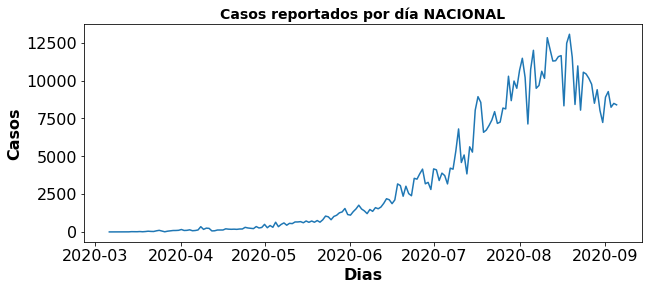

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(casos_dia_NAL['fecha_reporte_web'], casos_dia_NAL['Casos'] )

ax.set_title('Casos reportados por día NACIONAL', fontsize = 14, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Dias', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Casos', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)

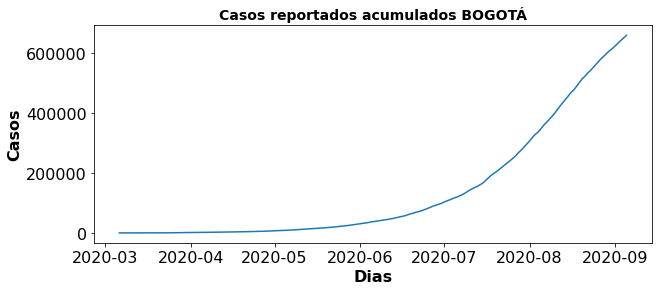

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(casos_dia_NAL['fecha_reporte_web'], casos_dia_NAL['Casos_acumulados'] )

ax.set_title('Casos reportados acumulados BOGOTÁ', fontsize = 14, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Dias', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Casos', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)

####Bogotá

In [ ]:
#BOGOTÁ
## COMPUTAMOS LOS CASOS POR DÍA Y ACUMULADOS DESDE EL INICIO DE LA PANDEMIA:
casos_dia_BOG = casos_imp.copy()
casos_dia_BOG= casos_dia_BOG[casos_dia_BOG['Ciudad_de_ubicación'].isin(['Bogotá D.C.'])]
casos_dia_BOG['Casos']=1
casos_dia_BOG = casos_dia_BOG.groupby('fecha_reporte_web')['Casos'].sum().reset_index()
casos_dia_BOG['Casos_acumulados'] = casos_dia_BOG['Casos'].cumsum()
#casos_dia_BOG

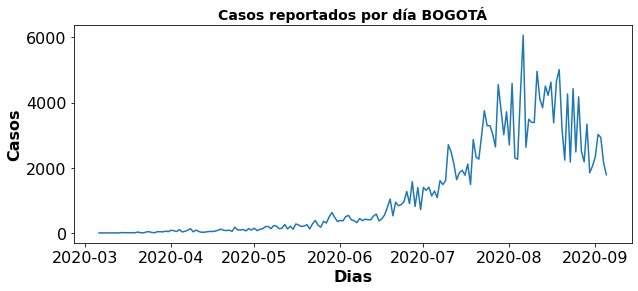

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(casos_dia_BOG['fecha_reporte_web'], casos_dia_BOG['Casos'] )

ax.set_title('Casos reportados por día BOGOTÁ', fontsize = 14, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Dias', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Casos', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)

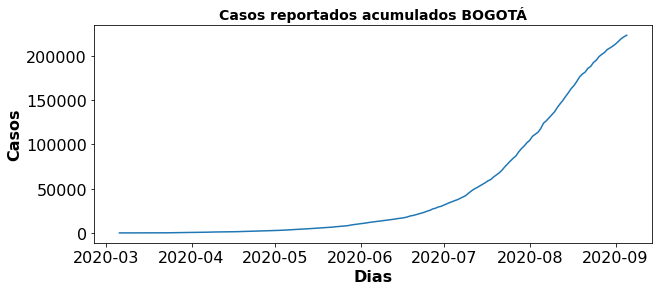

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(casos_dia_BOG['fecha_reporte_web'], casos_dia_BOG['Casos_acumulados'] )

ax.set_title('Casos reportados acumulados BOGOTÁ', fontsize = 14, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Dias', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Casos', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)

####Medellín

In [ ]:
#MEDELLÍN
## COMPUTAMOS LOS CASOS POR DÍA Y ACUMULADOS DESDE EL INICIO DE LA PANDEMIA:
casos_dia_MED = casos_imp.copy()
casos_dia_MED= casos_dia_MED[casos_dia_MED['Ciudad_de_ubicación'].isin(['Medellín'])]
casos_dia_MED['Casos']=1
casos_dia_MED = casos_dia_MED.groupby('fecha_reporte_web')['Casos'].sum().reset_index()
casos_dia_MED['Casos_acumulados'] = casos_dia_MED['Casos'].cumsum()
#casos_dia_MED

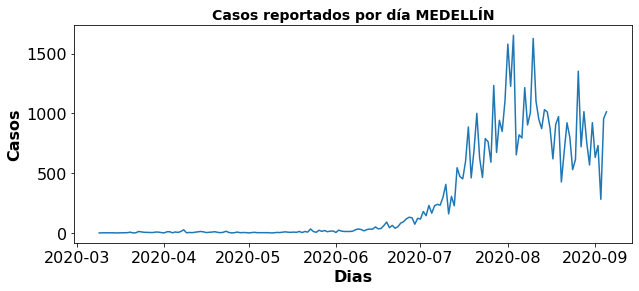

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(casos_dia_MED['fecha_reporte_web'], casos_dia_MED['Casos'] )

ax.set_title('Casos reportados por día MEDELLÍN', fontsize = 14, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Dias', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Casos', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)

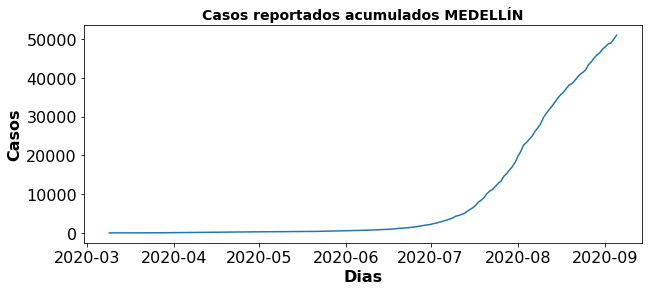

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(casos_dia_MED['fecha_reporte_web'], casos_dia_MED['Casos_acumulados'] )

ax.set_title('Casos reportados acumulados MEDELLÍN', fontsize = 14, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Dias', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Casos', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)

####Cali

In [ ]:
#CALI
## COMPUTAMOS LOS CASOS POR DÍA Y ACUMULADOS DESDE EL INICIO DE LA PANDEMIA:
casos_dia_CAL = casos_imp.copy()
casos_dia_CAL= casos_dia_CAL[casos_dia_CAL['Ciudad_de_ubicación'].isin(['Cali'])]
casos_dia_CAL['Casos']=1
casos_dia_CAL = casos_dia_CAL.groupby('fecha_reporte_web')['Casos'].sum().reset_index()
casos_dia_CAL['Casos_acumulados'] = casos_dia_CAL['Casos'].cumsum()
casos_dia_CAL

,fecha_reporte_web,Casos,Casos_acumulados
0,2020-03-13,1,1
1,2020-03-16,2,3
2,2020-03-17,5,8
3,2020-03-20,1,9
4,2020-03-21,6,15
...,...,...,...
167,2020-09-01,564,37427
168,2020-09-02,382,37809
169,2020-09-03,261,38070
170,2020-09-04,396,38466


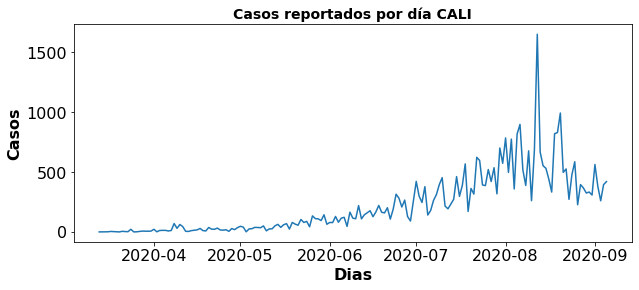

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(casos_dia_CAL['fecha_reporte_web'], casos_dia_CAL['Casos'] )

ax.set_title('Casos reportados por día CALI', fontsize = 14, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Dias', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Casos', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)

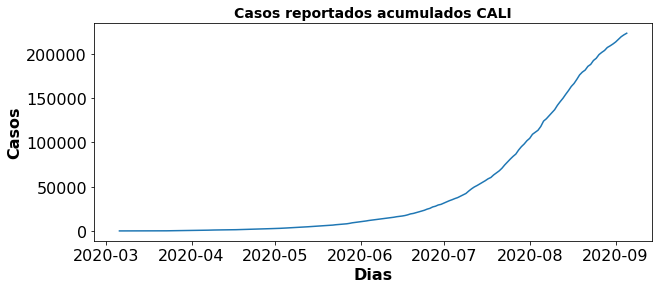

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(casos_dia_BOG['fecha_reporte_web'], casos_dia_BOG['Casos_acumulados'] )

ax.set_title('Casos reportados acumulados CALI', fontsize = 14, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Dias', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Casos', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)

####Barranquilla

In [ ]:
#BARRANQUILLA
## COMPUTAMOS LOS CASOS POR DÍA Y ACUMULADOS DESDE EL INICIO DE LA PANDEMIA:
casos_dia_BAQ = casos_imp.copy()
casos_dia_BAQ= casos_dia_BAQ[casos_dia_BAQ['Ciudad_de_ubicación'].isin(['Barranquilla'])]
casos_dia_BAQ['Casos']=1
casos_dia_BAQ = casos_dia_BAQ.groupby('fecha_reporte_web')['Casos'].sum().reset_index()
casos_dia_BAQ['Casos_acumulados'] = casos_dia_BAQ['Casos'].cumsum()
#casos_dia_BAQ

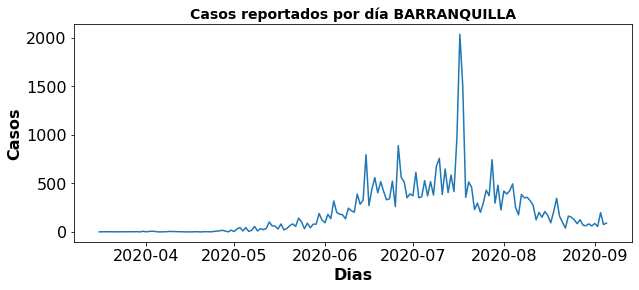

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(casos_dia_BAQ['fecha_reporte_web'], casos_dia_BAQ['Casos'] )

ax.set_title('Casos reportados por día BARRANQUILLA', fontsize = 14, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Dias', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Casos', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)

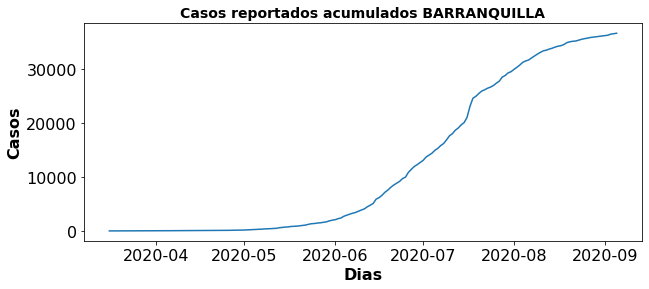

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(casos_dia_BAQ['fecha_reporte_web'], casos_dia_BAQ['Casos_acumulados'] )

ax.set_title('Casos reportados acumulados BARRANQUILLA', fontsize = 14, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Dias', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Casos', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)

####Cartagena

In [ ]:
#CARTAGENA
## COMPUTAMOS LOS CASOS POR DÍA Y ACUMULADOS DESDE EL INICIO DE LA PANDEMIA:
casos_dia_CAR = casos_imp.copy()
casos_dia_CAR= casos_dia_CAR[casos_dia_CAR['Ciudad_de_ubicación'].isin(['Cartagena de Indias'])]
casos_dia_CAR['Casos']=1
casos_dia_CAR = casos_dia_CAR.groupby('fecha_reporte_web')['Casos'].sum().reset_index()
casos_dia_CAR['Casos_acumulados'] = casos_dia_CAR['Casos'].cumsum()
#casos_dia_CAR

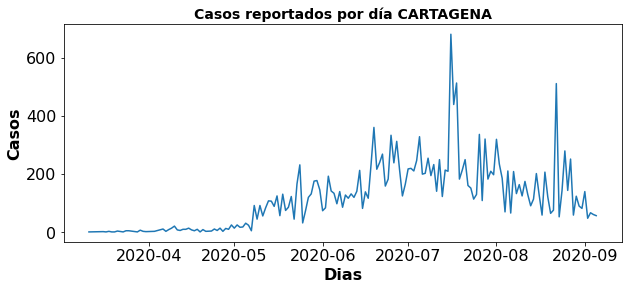

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(casos_dia_CAR['fecha_reporte_web'], casos_dia_CAR['Casos'] )

ax.set_title('Casos reportados por día CARTAGENA', fontsize = 14, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Dias', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Casos', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)

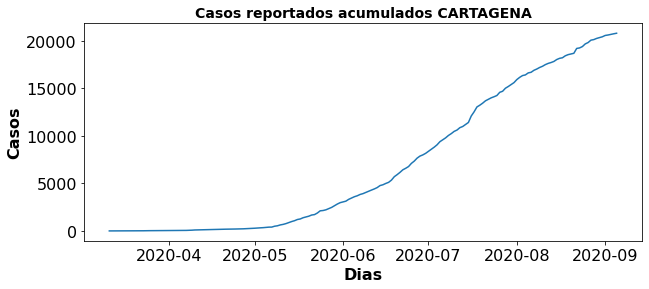

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(casos_dia_CAR['fecha_reporte_web'], casos_dia_CAR['Casos_acumulados'] )

ax.set_title('Casos reportados acumulados CARTAGENA', fontsize = 14, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Dias', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Casos', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)

# MODELO

El modelo desarrollado es un modelo híbrido con enfoque determinístico. Para ello se realizan combinatorias de un modelo de corto plazo y uno de mediano-largo plazo. Para el corto plazo se pronostica con un modelo **ARIMA**-Seasoned que, dado el comportamiento irregular del número de casos reportados, activos, recuperados y fallecidos, capta posibles un posible aumento o disminución de acuerdo al número de casos. 

Este se irá mezclando paulatinamente con un modelo de mediano-largo plazo como el **SIR**, dado que el primero presenta un error significativo cuando tiende al largo plazo. De esta manera, se obtendrá para cada ciudad un pronóstico soportado en ambos modelos, integrando la autocorrección a partir de nuevos datos.


## MODELO SIR



El modelo SIR, es un modelo de tipo compartimental ampliamente usado en el estudio del comportamiento de fenómenos epidemiológicos. Este clasifica la población en tres grupos Susceptibles (S), Infectados (I)  y recuperados (R), evaluando las interacciones entre estos modelos y tomando como principales parámetros de entrada el número de individuos en la población y la tasa de contagio. De acuerdo a lo anterior se evidencia que al tener un historico de datos suficiente para comprender la historia natural de la enfermedad, se podrán adelantar acercamientos que permitan predecir su comportamiento en diferentes ventanas de tiempo.

Este modelo en su forma estándar realiza un fuerte supuesto, dado que asume que la población pasará por cada grupo en algún momento del ciclo de vida del virus, es decir que se superará a partir de lo que los epidemiólogos llaman 'inmunidad de rebaño'

Sin embargo, las evidencias constatan que la tasa de infección y la posibilidad de contar con una vacuna entre el mediano y largo plazo, hace débil la hipotesis de que el virus llegue a todos los individuos de la población.

***


## ARIMA

Autoregressive Integrated Moving Average


(p, d,q): p, d t q son enteros no negativos.

Los parámetros tienen su significado habitual, aquí, p representa el orden de autoregresión, d representa el
grado de diferencia de tendencia (el número de veces que se han restado valores pasados ​​a los datos) para el
estacionario de la tendencia y q significa el orden de la media móvil. Este modelo combina la regresión automática
se retrasa por debajo de la tendencia estacionaria y la media móvil y predice mejores valores futuros basados ​​en
datos recientes. Para este modelo, el grado de los parámetros p, d y q se determinan con base en el gráfico de la función de autocorrelación parcial.
 (PACF), la prueba Dickey-Fuller aumentada para probar el estacionario del tiempo.
observaciones en serie y el gráfico de la función de autocorrelación completa (ACF) respectivamente.


𝐴𝑅𝐼𝑀A (𝑝, d, q): 𝑋𝑡=𝛼1 𝑋𝑡 −1+𝛼2 𝑋𝑡 −2+𝛽1𝑍𝑡−1 𝛽2 𝑍𝑡 −2+ 𝑍t 

Where, 𝑍𝑡 =𝑋𝑡−𝑋𝑡−1


Aquí, Xt es el número previsto de casos de COVID-19 activos y confirmados en el día t; α1, α2, β1 y β2
son parámetros mientras que Zt es el término residual para el día t.
La tendencia de las próximas incidencias se puede estimar a partir de los casos anteriores y un análisis de series de tiempo
se realiza para este propósito


AR: Auto regresiva.

MA: Media movil (Movil average)

1. Auto regresiva:
Para la parte autoregresiva es necesario definir si el conjunto de datos de covid presentan un comportamiento estacional o no. En el caso que se ponga de supuesto la no-estacionalidad de los datos, se aplicará el modelo ARIMA, siguiendo el modelo ARIMA(p, d, q).
En caso de tomar como supuesto la estacionalidad de los datos, se aplcará SARIMA (Seasoned ARIMA), siguiendo el modelo ARIMA(p,d,q)(P,D,Q)s, donde p,d y q son los parametros no estacionales del modelo y P,D Q, siguen la misma definición de las primeras tres variables pero esta vez aplicables al componente estacional de la serie de tiempo.

Respecto a p, suponemos la variable depende del valor rezagado inmediatamente anterior, por lo tanto tiene valor 1.

La parte integrada se refiere al orden de diferenciación. El orden de diferenciación no estacional se denota por d y el orden de diferenciación estacional por D. La parte integrada es esencial cuando la serie es no estacionaria.
Para este caso supondremos que es no estacionaria, por lo que d tendría un valor de 1

In [ ]:
import statsmodels.api as sm
from pandas.plotting import autocorrelation_plot
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [ ]:
# reindexar el dataframe para los datos de Cartagena.
datos_arima_CAR = casos_dia_CAR.copy()
datos_arima_CAR['fecha_reporte_web'] = pd.to_datetime(datos_arima_CAR['fecha_reporte_web'])
datos_arima_CAR.set_index(['fecha_reporte_web'],inplace=True)
datos_arima_CAR = datos_arima_CAR[['Casos']]

In [ ]:
# reindexar el dataframe para los datos de Barranquilla.
datos_arima_BAQ = casos_dia_BAQ.copy()
datos_arima_BAQ['fecha_reporte_web'] = pd.to_datetime(datos_arima_BAQ['fecha_reporte_web'])
datos_arima_BAQ.set_index(['fecha_reporte_web'],inplace=True)
datos_arima_BAQ = datos_arima_BAQ[['Casos']]

In [ ]:
# reindexar el dataframe para los datos de Cali.
datos_arima_CAL = casos_dia_CAL.copy()
datos_arima_CAL['fecha_reporte_web'] = pd.to_datetime(datos_arima_CAL['fecha_reporte_web'])
datos_arima_CAL.set_index(['fecha_reporte_web'],inplace=True)
datos_arima_CAL = datos_arima_CAL[['Casos']]

In [ ]:
# reindexar el dataframe para los datos de Medellín.
datos_arima_MED = casos_dia_MED.copy()
datos_arima_MED['fecha_reporte_web'] = pd.to_datetime(datos_arima_MED['fecha_reporte_web'])
datos_arima_MED.set_index(['fecha_reporte_web'],inplace=True)
datos_arima_MED = datos_arima_MED[['Casos']]

In [ ]:
# reindexar el dataframe para los datos de Bogotá.
datos_arima_BOG = casos_dia_BOG.copy()
datos_arima_BOG['fecha_reporte_web'] = pd.to_datetime(datos_arima_BOG['fecha_reporte_web'])
datos_arima_BOG.set_index(['fecha_reporte_web'],inplace=True)
datos_arima_BOG = datos_arima_BOG[['Casos']]

In [ ]:
# reindexar el dataframe para los datos nacionales.
datos_arima_NAL = casos_dia_NAL.copy()
datos_arima_NAL['fecha_reporte_web'] = pd.to_datetime(datos_arima_NAL['fecha_reporte_web'])
datos_arima_NAL.set_index(['fecha_reporte_web'],inplace=True)
datos_arima_NAL = datos_arima_NAL[['Casos']]

## Análisis de Parámetros ARIMA

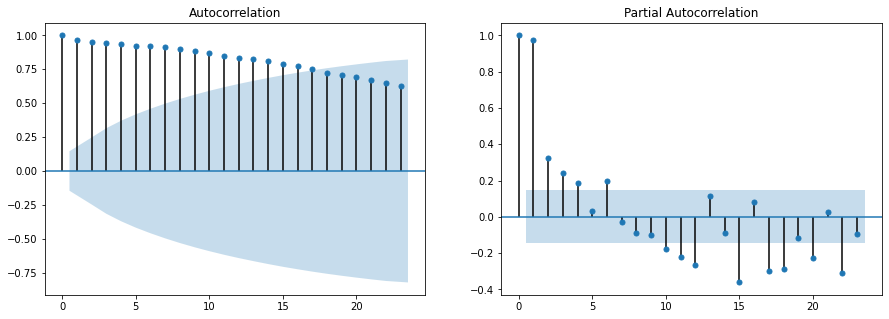

In [ ]:
## Análisis de autocorrelación de los datos con una confianza del 95%.

fig, ax = plt.subplots(1,2,figsize=(15,5))
plot_acf(datos_arima_NAL, alpha=0.05, ax=ax[0]).show()
plot_pacf(datos_arima_NAL,  alpha=0.05, ax=ax[1]).show()
plt.show()

Los analisis realizados sobre gráficos de autocorrelación y autocorrelación parcial generados para cada set de datos sirvieron de soporte para la escogencia de los parámetros de entrada del modelo ARIMA.

Así mismo de la herramienta autoarima, con la cual se analizaba la combinación que de acuerdo a cada set de datos, permitia minimizar el criterio de información de Akaike AIC, el cual, a pesar de no medir la calidad del modelo en términos de la predictibilidad, da cuenta de un nivel de ajuste.

In [ ]:
## Training rate.
TR=0.80

La serie no parece estacionaria, ya que muestra una tendencia creciente. Tendremos que hacer diferenciación de datos para hacer estacionaria la serie, integrada de orden 1, denotada por d (para diff), uno de los parámetros del modelo ARIMA.

**Modelo SIR**

Para construir este modelo se tuvo en cuenta tres variables (Recuperados, Infectados y Casos Activos). Se entiende por casos activos aquellos que no se reportaron nunca como recuperados ni fallecidos.

Posterior a ello se definió un s_0 como la población total tanto para Colombia como para las ciudades principales, un i_0 como los infectados iniciales y r_0 como los recuperados iniciales, respecto al beta y gamma el modelo está diseñado para que calcule los valores optimos.

Teniendo en cuenta que este modelo plantea que toda la población es susceptible a infectarse se generan unos picos muy altos en algún momento del tiempo, por lo que se decidió plantear dos escenarios , uno a corto plazo (100 días) con el fin de identificar tendencias en los próximos días y otro a largo plazo(1000 días) para conocer en qué punto del tiempo la pandemia llega al pico más alto y empieza a descender.


In [ ]:
#Definir funciones

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h


def loss(point, data, recovered, s_0, i_0, r_0):
    size = len(data)
    beta, gamma = point
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I/s_0, beta*S*I/s_0-gamma*I, gamma*I]
    solution = solve_ivp(SIR, [0, size], [s_0,i_0,r_0], t_eval=np.arange(0, size, 1), vectorized=True)
    l1 = np.sqrt(np.mean((solution.y[1] - data)**2))
    l2 = np.sqrt(np.mean((solution.y[2] - recovered)**2))
    alpha = 0.1
    return alpha * l1 + (1 - alpha) * l2

def predict(beta, gamma, data, recovered, s_0, i_0, r_0):
    new_index = pres_fut
    size = len(new_index)
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I/s_0, beta*S*I/s_0-gamma*I, gamma*I]
    extended_actual = np.concatenate((data.values, [None] * (size - len(data.values))))
    extended_recovered = np.concatenate((recovered.values, [None] * (size - len(recovered.values))))
    return new_index, extended_actual, extended_recovered, solve_ivp(SIR, [0, size], [s_0,i_0,r_0], t_eval=np.arange(0, size, 1))

def train(recovered, infected, data):
    recovered = recovered
    infected = infected
    data = data

    optimal = minimize(loss, [0.001, 0.001], args=(data, recovered, s_0, i_0, r_0), method='L-BFGS-B', bounds=[(0.000001, 0.5), (0.00000001, 0.4)])
    print(optimal)
    beta, gamma = optimal.x
    new_index, extended_actual, extended_recovered, prediction = predict(beta, gamma, data, recovered, s_0, i_0, r_0)
    df = pd.DataFrame({'Infectados actuales': extended_actual, 'Recuperados Actuales': extended_recovered, 'Susceptibles': prediction.y[0], 'Predicción Infectados': prediction.y[1], 'Predicción Recuperados': prediction.y[2]}, index=new_index)
    fig, ax = plt.subplots(1,3,figsize=(14, 6))
    df.plot(ax=ax[0],title='Covid Colombia')
    df['Predicción Infectados'].plot(ax=ax[1],title='Predicción Infectados')
    df['Predicción Recuperados'].plot(ax=ax[2],title='Predicción Recuperados')
    print('El intervalo de confianza es:' , mean_confidence_interval(df['Predicción Infectados'], confidence=0.95))
    #plt.savefig('Imagen.png') - Para guardar la figura
    print(f"country=Colombia, beta={beta:.8f}, gamma={gamma:.8f}, r_0:{(beta/gamma):.8f}")
    return df.tail(100)

###NACIONAL

#### Nacional SIR

In [ ]:
df3=df2.copy()
df3['Activos']= np.where(df3['cantidad_reporte'] - df3['cantidad_recuperados']- df3['cantidad_muertes']<0, 0, df3['cantidad_reporte']-df3['cantidad_recuperados']-df3['cantidad_muertes'])

data = df3.set_index('f_reporte')['Activos']
infected = df3.set_index('f_reporte')['cantidad_reporte']
recovered = df3.set_index('f_reporte')['cantidad_recuperados']

**Corto Plazo - 100 Días**

      fun: 1353.8505747767726
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.10581971, -0.08765255])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 57
      nit: 8
   status: 0
  success: True
        x: array([0.07945428, 0.05774153])
El intervalo de confianza es: (7177.38734282147, 5967.743073749254, 8387.031611893686)
country=Colombia, beta=0.07945428, gamma=0.05774153, r_0:1.37603360


,Infectados actuales,Recuperados Actuales,Susceptibles,Predicción Infectados,Predicción Recuperados
2020-09-06,None,None,4.998176e+07,5082.551275,13335.063941
2020-09-07,None,None,4.998135e+07,5194.160837,13632.273992
2020-09-08,None,None,4.998093e+07,5308.213255,13935.998820
2020-09-09,None,None,4.998050e+07,5424.758154,14246.371100
2020-09-10,None,None,4.998007e+07,5543.845837,14563.525325
...,...,...,...,...,...
2020-12-10,None,None,4.985482e+07,39620.817613,105735.693188
2020-12-11,None,None,4.985165e+07,40481.065767,108048.221758
2020-12-12,None,None,4.984841e+07,41359.783981,110410.964510
2020-12-13,None,None,4.984509e+07,42257.357697,112824.993640


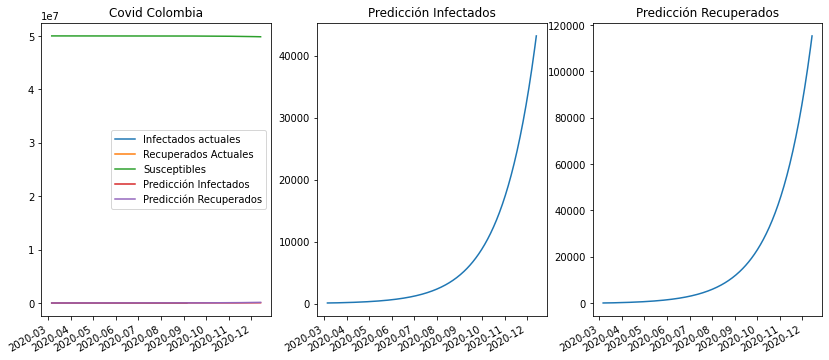

In [ ]:
#Poblacion inicial , infectados y recuperados
s_0 = 50000000
i_0 = 100
r_0 = 76
pres_fut = np.array(list(data.index.values)+ list((np.array(pd.date_range('2020-09-06', periods=100))))) #Periodo a predecir

train(recovered, infected, data)

**Largo Plazo - 1000 Días**

      fun: 1779.0251555080101
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([   1.25035058, -655.15787355])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 81
      nit: 10
   status: 0
  success: True
        x: array([0.44135828, 0.4       ])
El intervalo de confianza es: (19208.367486130814, 16327.584198176279, 22089.15077408535)
country=Colombia, beta=0.44135828, gamma=0.40000000, r_0:1.10339571


,Infectados actuales,Recuperados Actuales,Susceptibles,Predicción Infectados,Predicción Recuperados
2023-02-23,None,None,4.092528e+07,1.462514e-07,9.074725e+06
2023-02-24,None,None,4.092528e+07,1.473105e-07,9.074725e+06
2023-02-25,None,None,4.092528e+07,1.496812e-07,9.074725e+06
2023-02-26,None,None,4.092528e+07,1.532840e-07,9.074725e+06
2023-02-27,None,None,4.092528e+07,1.580331e-07,9.074725e+06
...,...,...,...,...,...
2023-05-29,None,None,4.092528e+07,1.175823e-07,9.074725e+06
2023-05-30,None,None,4.092528e+07,1.180836e-07,9.074725e+06
2023-05-31,None,None,4.092528e+07,1.176681e-07,9.074725e+06
2023-06-01,None,None,4.092528e+07,1.162556e-07,9.074725e+06


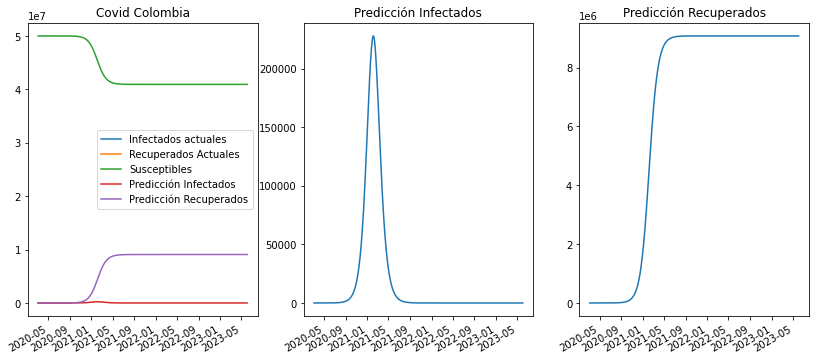

In [ ]:
#Poblacion inicial , infectados y recuperados
s_0 = 50000000
i_0 = 1
r_0 = 0.7
pres_fut = np.array(list(data.index.values)+ list((np.array(pd.date_range('2020-09-06', periods=1000))))) #Periodo a predecir

train(recovered, infected, data)

#### Nacional ARIMA

Reindexar los datos para cada ciudad.

In [ ]:
#Actualizo el df temporal con la ciudad.
datos_arima_XX = datos_arima_NAL.copy()
## Separo los valores entre train y test.
train_size = int(len(datos_arima_XX) * 0.75)
test_size = len(datos_arima_XX) - train_size
train_data, test_data = datos_arima_XX[0:train_size], datos_arima_XX[train_size:]

In [ ]:
auto_arima(train_data, seasonal=True, m=22,max_p=7, max_d=5,max_q=7, max_P=4, max_D=4,max_Q=4).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  135
Model:             SARIMAX(2, 1, 4)x(0, 1, [], 22)   Log Likelihood                -836.064
Date:                             Mon, 07 Sep 2020   AIC                           1686.127
Time:                                     03:56:20   BIC                           1705.157
Sample:                                          0   HQIC                          1693.848
                                             - 135                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2585      0.051     24.517      0.000       1.158       1.359
ar.L2         -1.0000      0.046    -21.682      0.000      -1.090      -0.910
ma.L1         -2.0672      0.105    -19.691      0.000      -2.273      -1.861
ma.L2          2.3687      0.182     12.988      0.000       2.011       2.726
ma.L3         -1.4373      0.166     -8.672      0.000      -1.762      -1.112
ma.L4          0.4717      0.092      5.110      0.000       0.291       0.653
sigma2      1.745e+05   1.93e+04      9.034      0.000    1.37e+05    2.12e+05
===================================================================================
Ljung-Box (Q):                       31.51   Jarque-Bera (JB):                45.32
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):              37.27   Skew:                             0.41
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Train

In [ ]:
# ESTABLEZCO EL TAMAÑO ESTACIONAL QUE DE ACUERDO A LOS DATOS DE 'TEST' DISMINUYA EL ERROR ABSOLUTO PROMEDIO.
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
## Generar los parámetros del ARIMA, a partir del train data.
MAE = []
for x in range(15, 26):
  mod = sm.tsa.statespace.SARIMAX(train_data['Casos'],
                                  order=(0, 1, 2),
                                  seasonal_order=(0, 1, 1, x),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)

  results = mod.fit()

  ## Genero las predicciones.
  arima_pred = results.predict(start = len(train_data)+1, end = len(datos_arima_XX) , dynamic=False, typ="levels").rename("Pronostico")

  ## Genero la lista de dias para indexar el df 'arima_pred'.
  dateList = []
  dateList = [test_data.index[0] + datetime.timedelta(days = x) for x in range (0, len(arima_pred))]

  ## Convierto la serie en df y pongo la fecha como index
  arima_pred = pd.DataFrame(data=arima_pred, columns=['Pronostico'])
  arima_pred['fecha_reporte_web'] = dateList
  arima_pred = arima_pred.set_index(['fecha_reporte_web'])

  ## Creo df para comparar train y test.
  metric_df = arima_pred.join(datos_arima_XX['Casos'])
  metric_df.dropna(inplace=True)
  
  MAE.append([x, mean_absolute_error(metric_df.Casos, metric_df.Pronostico)])
minMAE = pd.DataFrame(MAE,columns=['Tamaño_estac','Error'])
E = minMAE['Tamaño_estac'].loc[minMAE['Error'].idxmin()]


In [ ]:
## Generar los parámetros del ARIMA, a partir del train data.
mod = sm.tsa.statespace.SARIMAX(train_data['Casos'],
                                order=(0, 1, 2),
                                seasonal_order=(0, 1, 1, E),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3361      0.047     -7.139      0.000      -0.428      -0.244
ma.L2         -0.2203      0.078     -2.827      0.005      -0.373      -0.068
ma.S.L17      -0.7173      0.198     -3.629      0.000      -1.105      -0.330
sigma2      3.713e+05   3.17e+04     11.719      0.000    3.09e+05    4.33e+05


 Test


In [ ]:
## Genero las predicciones.
arima_pred = results.predict(start = len(train_data)+1, end = len(datos_arima_XX) , dynamic=False, typ="levels").rename("Pronostico")

## Genero la lista de dias para indexar el df 'arima_pred'
dateList = []
dateList = [test_data.index[0] + datetime.timedelta(days = x) for x in range (0, len(arima_pred))]

## Convierto la serie en df y pongo la fecha como index
arima_pred = pd.DataFrame(data=arima_pred, columns=['Pronostico'])
arima_pred['fecha_reporte_web'] = dateList
#casos['fecha_reporte_web'] = pd.to_datetime(casos['fecha_reporte_web']) #Convertir a fecha
arima_pred = arima_pred.set_index(['fecha_reporte_web'])


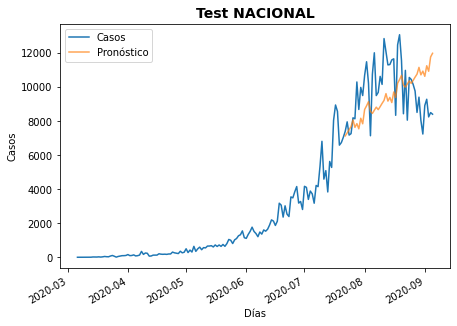

In [ ]:
ax = datos_arima_XX['2020':].plot(label='Reales',figsize=(7, 5))
arima_pred['Pronostico'].plot(ax=ax, label='Pronóstico', alpha=.7)

conf_int = 2 * arima_pred.std()

#plt.fill_between(conf_int.index, 
#                 arima_pred-conf_int, 
#                 arima_pred+conf_int, 
#                 color='b', alpha=.1)
ax.set_title('Test NACIONAL', fontsize = 14, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Días')
ax.set_ylabel('Casos')
plt.legend()

plt.show()

In [ ]:
## Creo df para comparar train y test.
metric_df = arima_pred.join(datos_arima_XX['Casos'])
metric_df.dropna(inplace=True)

In [ ]:
r2_score(metric_df['Casos'], metric_df["Pronostico"])

-0.46126661226363175

In [ ]:
prophet_rmse_error = rmse(metric_df['Casos'], metric_df["Pronostico"])
prophet_mse_error = prophet_rmse_error**2

print(f'MSE Error: {prophet_mse_error}\nRMSE Error: {prophet_rmse_error}')

MSE Error: 3857156.092957291
RMSE Error: 1963.9643817944589


In [ ]:
mean_absolute_error(metric_df.Casos, metric_df.Pronostico)

1692.9009069250985

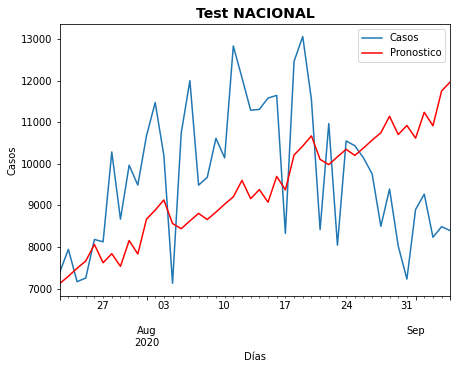

In [ ]:
ax=test_data.plot(legend=True, figsize=(7,5))
arima_pred.plot(ax=ax,legend = True, color='red')
ax.set_title('Test NACIONAL', fontsize = 14, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Días')
ax.set_ylabel('Casos')
plt.show()


Generalización

In [ ]:
last_day = 100    ##Cantidad de dias a predecir.

In [ ]:
## Genero las predicciones.
arima_pred_NAL = results.predict(start = len(train_data)+1, end = len(train_data)+1+last_day , typ="levels").rename("Pronostico")

## Genero la lista de dias para indexar el df 'arima_pred'
dateList = []
dateList = [test_data.index[0] + datetime.timedelta(days = x) for x in range (0, len(arima_pred_NAL))]

## Convierto la serie en df y pongo la fecha como index
arima_pred_NAL = pd.DataFrame(data=arima_pred_NAL, columns=['Pronostico'])
arima_pred_NAL['fecha_reporte_web'] = dateList
arima_pred_NAL = arima_pred_NAL.set_index(['fecha_reporte_web'])


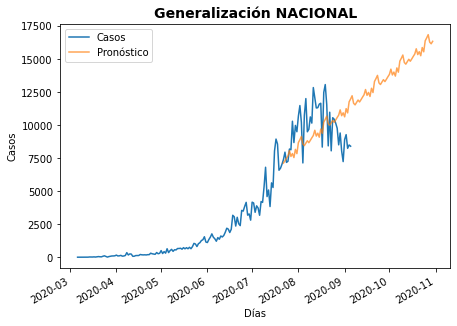

In [ ]:
ax = datos_arima_XX['2020':].plot(label='Reales',figsize=(7, 5))
arima_pred_NAL['Pronostico'].plot(ax=ax, label='Pronóstico', alpha=.7)

#ax.fill_between(pred_ci.index,
#                pred_ci.iloc[:, 0],
#                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_title('Generalización NACIONAL', fontsize = 14, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Días')
ax.set_ylabel('Casos')
plt.legend()

plt.show()

###BOGOTÁ

####Bogotá D.C. SIR

In [ ]:
casos_dia_SIR_BOG = casos_imp_SIR.copy()
casos_dia_SIR_BOG= casos_dia_SIR_BOG[casos_dia_SIR_BOG['Ciudad_de_ubicación'].isin(['Bogotá D.C.'])]
dff=casos_dia_SIR_BOG.copy()
ff_reporte=pd.DataFrame()
ff_reporte['cantidad_reporte']=dff.groupby('fecha_reporte_web').size()
ff_reporte['f_reporte']=ff_reporte.index
Dff1=dff[dff['atención'] == 'Fallecido']
ff_muerte=pd.DataFrame()
ff_muerte['cantidad_muertes']=Dff1.groupby('Fecha_de_muerte').size()
ff_muerte['f_muerte']=ff_muerte.index
Dff2=dff[dff['atención'] == 'Recuperado']
ff_recuperado=pd.DataFrame()
ff_recuperado['cantidad_recuperados']=Dff2.groupby('Fecha_recuperado').size()
ff_recuperado['f_recuperados']=ff_recuperado.index
consf1=pd.merge(ff_reporte, ff_muerte, left_on='f_reporte', right_on='f_muerte', how='left')
consf=pd.merge(consf1, ff_recuperado, left_on='f_reporte', right_on='f_recuperados', how='left')
cols1 = ['f_reporte', 'cantidad_reporte','cantidad_recuperados','cantidad_muertes']
dff1=consf[cols1]
dff2 = dff1.fillna(0)
dff3=dff2.copy()
dff3['Activos']=abs(dff3['cantidad_reporte']-dff3['cantidad_recuperados']-dff3['cantidad_muertes'])
data = dff3.set_index('f_reporte')['Activos']
infected = dff3.set_index('f_reporte')['cantidad_reporte']
recovered = dff3.set_index('f_reporte')['cantidad_recuperados']

**Corto Plazo - 100 Días**

      fun: 750.7730084907704
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.00844693, 0.00251248])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 78
      nit: 11
   status: 0
  success: True
        x: array([0.04558199, 0.02700955])
El intervalo de confianza es: (3411.4752972890997, 2900.241823701551, 3922.7087708766485)
country=Colombia, beta=0.04558199, gamma=0.02700955, r_0:1.68762520


,Infectados actuales,Recuperados Actuales,Susceptibles,Predicción Infectados,Predicción Recuperados
2020-09-06,None,None,7.493309e+06,2824.275635,4042.311344
2020-09-07,None,None,7.493180e+06,2876.984076,4119.128684
2020-09-08,None,None,7.493048e+06,2930.674925,4197.380497
2020-09-09,None,None,7.492914e+06,2985.367388,4277.095005
2020-09-10,None,None,7.492777e+06,3041.081041,4358.300987
...,...,...,...,...,...
2020-12-10,None,None,7.460053e+06,16313.444260,23809.844585
2020-12-11,None,None,7.459306e+06,16615.275163,24254.667390
2020-12-12,None,None,7.458546e+06,16922.599128,24707.698769
2020-12-13,None,None,7.457771e+06,17235.509168,25169.081260


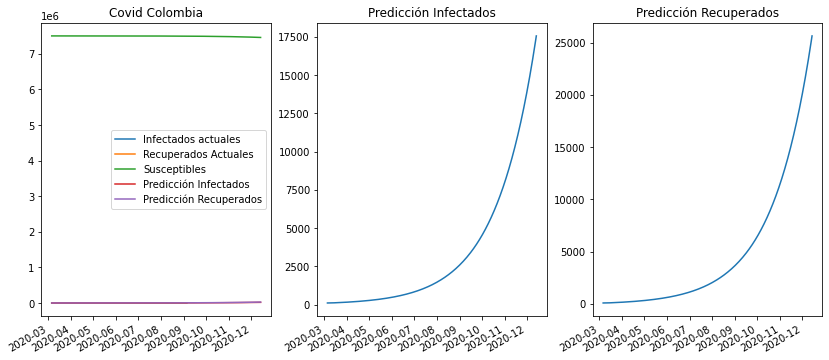

In [ ]:
s_0 = 7500000
i_0 = 100
r_0 = 76
pres_fut = np.array(list(data.index.values)+ list((np.array(pd.date_range('2020-09-06', periods=100))))) # Días a predecir Bogotá
train(recovered, infected, data)

**Largo Plazo - 1000 Días**

      fun: 765.1553629872499
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 6.37101039e-02, -1.15765192e+02])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 189
      nit: 34
   status: 0
  success: True
        x: array([0.43398774, 0.4       ])
El intervalo de confianza es: (2422.3480566979706, 2097.3836262848736, 2747.3124871110676)
country=Colombia, beta=0.43398774, gamma=0.40000000, r_0:1.08496936


,Infectados actuales,Recuperados Actuales,Susceptibles,Predicción Infectados,Predicción Recuperados
2023-02-23,None,None,6.356611e+06,4.229306e-06,1.143391e+06
2023-02-24,None,None,6.356611e+06,4.099452e-06,1.143391e+06
2023-02-25,None,None,6.356611e+06,3.969370e-06,1.143391e+06
2023-02-26,None,None,6.356611e+06,3.841176e-06,1.143391e+06
2023-02-27,None,None,6.356611e+06,3.715124e-06,1.143391e+06
...,...,...,...,...,...
2023-05-29,None,None,6.356611e+06,2.705138e-07,1.143391e+06
2023-05-30,None,None,6.356611e+06,2.620594e-07,1.143391e+06
2023-05-31,None,None,6.356611e+06,2.538573e-07,1.143391e+06
2023-06-01,None,None,6.356611e+06,2.458945e-07,1.143391e+06


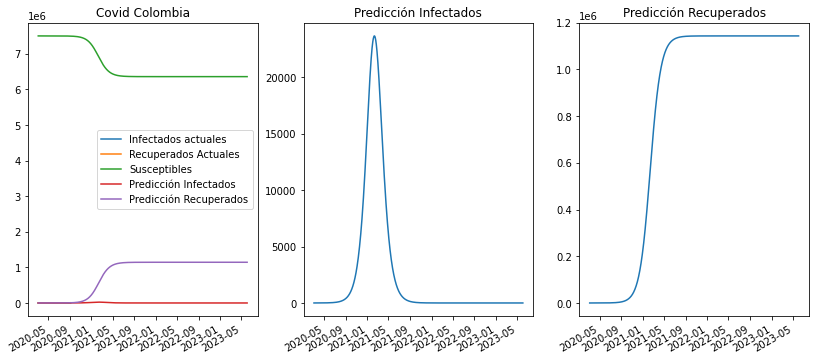

In [ ]:
s_0 = 7500000
i_0 = 1
r_0 = 0.76
pres_fut = np.array(list(data.index.values)+ list((np.array(pd.date_range('2020-09-06', periods=1000))))) # Días a predecir Bogotá
train(recovered, infected, data)

#### Bogotá ARIMA

In [ ]:
#Actualizo el df temporal con la ciudad.
datos_arima_XX = datos_arima_BOG.copy()
## Separo los valores entre train y test.
train_size = int(len(datos_arima_XX) * 0.75)
test_size = len(datos_arima_XX) - train_size
train_data, test_data = datos_arima_XX[0:train_size], datos_arima_XX[train_size:]

Train

In [ ]:
# ESTABLEZCO EL TAMAÑO ESTACIONAL QUE DE ACUERDO A LOS DATOS DE 'TEST' DISMINUYA EL ERROR ABSOLUTO PROMEDIO.
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
## Generar los parámetros del ARIMA, a partir del train data.
MAE = []
for x in range(15, 26):
  mod = sm.tsa.statespace.SARIMAX(train_data['Casos'],
                                  order=(1, 2, 2),
                                  seasonal_order=(1, 1, 1, x),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)

  results = mod.fit()

  ## Genero las predicciones.
  arima_pred = results.predict(start = len(train_data)+1, end = len(datos_arima_XX) , dynamic=False, typ="levels").rename("Pronostico")

  ## Genero la lista de dias para indexar el df 'arima_pred'.
  dateList = []
  dateList = [test_data.index[0] + datetime.timedelta(days = x) for x in range (0, len(arima_pred))]

  ## Convierto la serie en df y pongo la fecha como index
  arima_pred = pd.DataFrame(data=arima_pred, columns=['Pronostico'])
  arima_pred['fecha_reporte_web'] = dateList
  arima_pred = arima_pred.set_index(['fecha_reporte_web'])

  ## Creo df para comparar train y test.
  metric_df = arima_pred.join(datos_arima_XX['Casos'])
  metric_df.dropna(inplace=True)
  
  MAE.append([x, mean_absolute_error(metric_df.Casos, metric_df.Pronostico)])
minMAE = pd.DataFrame(MAE,columns=['Tamaño_estac','Error'])
E = minMAE['Tamaño_estac'].loc[minMAE['Error'].idxmin()]


In [ ]:
## Generar los parámetros del ARIMA, a partir del train data.
mod = sm.tsa.statespace.SARIMAX(train_data['Casos'],
                                order=(1, 2, 2),
                                seasonal_order=(1, 1, 1, E),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3611      0.256     -1.408      0.159      -0.864       0.141
ma.L1         -1.2887      0.347     -3.709      0.000      -1.970      -0.608
ma.L2          0.2806      0.299      0.937      0.349      -0.306       0.868
ar.S.L24      -0.9583      0.254     -3.770      0.000      -1.457      -0.460
ma.S.L24      -0.2509      0.382     -0.656      0.512      -1.000       0.498
sigma2      6.889e+04   1.29e+04      5.340      0.000    4.36e+04    9.42e+04


 Test


In [ ]:
## Genero las predicciones.
arima_pred = results.predict(start = len(train_data)+1, end = len(datos_arima_XX) , dynamic=False, typ="levels").rename("Pronostico")

## Genero la lista de dias para indexar el df 'arima_pred'
dateList = []
dateList = [test_data.index[0] + datetime.timedelta(days = x) for x in range (0, len(arima_pred))]

## Convierto la serie en df y pongo la fecha como index
arima_pred = pd.DataFrame(data=arima_pred, columns=['Pronostico'])
arima_pred['fecha_reporte_web'] = dateList
#casos['fecha_reporte_web'] = pd.to_datetime(casos['fecha_reporte_web']) #Convertir a fecha
arima_pred = arima_pred.set_index(['fecha_reporte_web'])


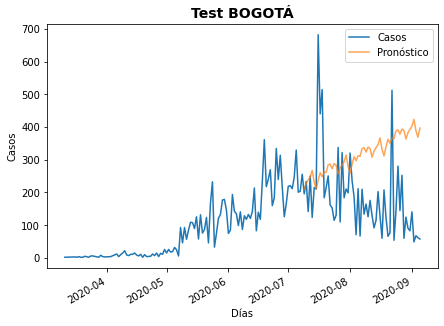

In [ ]:
ax = datos_arima_XX['2020':].plot(label='Reales',figsize=(7, 5))
arima_pred['Pronostico'].plot(ax=ax, label='Pronóstico', alpha=.7)

conf_int = 2 * arima_pred.std()

#plt.fill_between(conf_int.index, 
#                 arima_pred-conf_int, 
#                 arima_pred+conf_int, 
#                 color='b', alpha=.1)
ax.set_title('Test BOGOTÁ', fontsize = 14, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Días')
ax.set_ylabel('Casos')
plt.legend()

plt.show()

In [ ]:
## Creo df para comparar train y test.
metric_df = arima_pred.join(datos_arima_XX['Casos'])
metric_df.dropna(inplace=True)


In [ ]:
r2_score(metric_df['Casos'], metric_df["Pronostico"])

-1.8463775712569994

In [ ]:
prophet_rmse_error = rmse(metric_df['Casos'], metric_df["Pronostico"])
prophet_mse_error = prophet_rmse_error**2

print(f'MSE Error: {prophet_mse_error}\nRMSE Error: {prophet_rmse_error}')

MSE Error: 2812210.450471731
RMSE Error: 1676.9646539124583


In [ ]:
mean_absolute_error(metric_df.Casos, metric_df.Pronostico)

1293.0022234842384

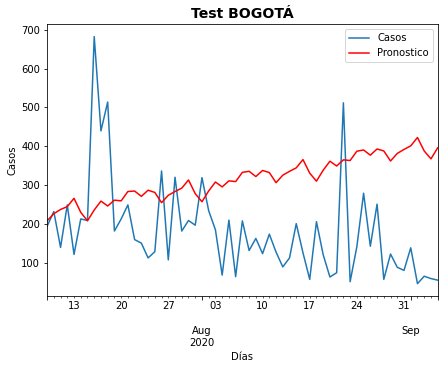

In [ ]:
ax=test_data.plot(legend=True, figsize=(7,5))
arima_pred.plot(ax=ax,legend = True, color='red')
ax.set_title('Test BOGOTÁ', fontsize = 14, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Días')
ax.set_ylabel('Casos')
plt.show()


Generalización

In [ ]:
last_day = 100    ##Cantidad de dias a predecir.

In [ ]:
## Genero las predicciones.
arima_pred_BOG = results.predict(start = len(train_data)+1, end = len(train_data)+1+last_day , typ="levels").rename("Pronostico")

## Genero la lista de dias para indexar el df 'arima_pred'
dateList = []
dateList = [test_data.index[0] + datetime.timedelta(days = x) for x in range (0, len(arima_pred_BOG))]

## Convierto la serie en df y pongo la fecha como index
arima_pred_BOG = pd.DataFrame(data=arima_pred_BOG, columns=['Pronostico'])
arima_pred_BOG['fecha_reporte_web'] = dateList
arima_pred_BOG = arima_pred_BOG.set_index(['fecha_reporte_web'])


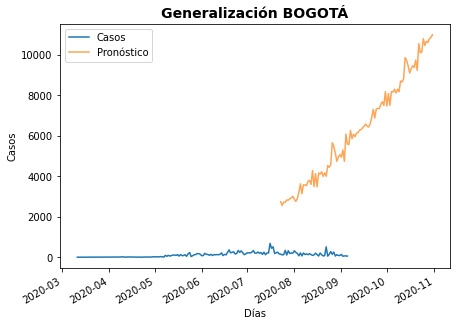

In [ ]:
ax = datos_arima_XX['2020':].plot(label='Reales',figsize=(7, 5))
arima_pred_BOG['Pronostico'].plot(ax=ax, label='Pronóstico', alpha=.7)

#ax.fill_between(pred_ci.index,
#                pred_ci.iloc[:, 0],
#                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_title('Generalización BOGOTÁ', fontsize = 14, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Días')
ax.set_ylabel('Casos')
plt.legend()

plt.show()

###MEDELLÍN

####Medellín SIR

In [ ]:
casos_dia_SIR_MED = casos_imp_SIR.copy()
casos_dia_SIR_MED= casos_dia_SIR_MED[casos_dia_SIR_MED['Ciudad_de_ubicación'].isin(['Medellín'])]
dfff=casos_dia_SIR_MED.copy()
fff_reporte=pd.DataFrame()
fff_reporte['cantidad_reporte']=dfff.groupby('fecha_reporte_web').size()
fff_reporte['f_reporte']=fff_reporte.index
Dfff1=dfff[dfff['atención'] == 'Fallecido']
fff_muerte=pd.DataFrame()
fff_muerte['cantidad_muertes']=Dfff1.groupby('Fecha_de_muerte').size()
fff_muerte['f_muerte']=fff_muerte.index
Dfff2=dfff[dfff['atención'] == 'Recuperado']
fff_recuperado=pd.DataFrame()
fff_recuperado['cantidad_recuperados']=Dfff2.groupby('Fecha_recuperado').size()
fff_recuperado['f_recuperados']=fff_recuperado.index
cons1ff=pd.merge(fff_reporte, fff_muerte, left_on='f_reporte', right_on='f_muerte', how='left')
consff=pd.merge(cons1ff, fff_recuperado, left_on='f_reporte', right_on='f_recuperados', how='left')
cols1 = ['f_reporte', 'cantidad_reporte','cantidad_recuperados','cantidad_muertes']
dfff1=consff[cols1]
dfff2 = dfff1.fillna(0)
dfff3=dfff2.copy()
dfff3['Activos']=abs(dfff3['cantidad_reporte']-dfff3['cantidad_recuperados']-dfff3['cantidad_muertes'])
data = dfff3.set_index('f_reporte')['Activos']
infected = dfff3.set_index('f_reporte')['cantidad_reporte']
recovered = dfff3.set_index('f_reporte')['cantidad_recuperados']


**Corto Plazo - 100 Días**

      fun: 210.82198929788538
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00998739, -0.00960654])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 81
      nit: 18
   status: 0
  success: True
        x: array([0.21940448, 0.18705767])
El intervalo de confianza es: (686.0481466972881, 537.8516852910163, 834.2446081035598)
country=Colombia, beta=0.21940448, gamma=0.18705767, r_0:1.17292427


,Infectados actuales,Recuperados Actuales,Susceptibles,Predicción Infectados,Predicción Recuperados
2020-09-06,None,None,2.998299e+06,251.415332,1451.593435
2020-09-07,None,None,2.998243e+06,259.661648,1499.469205
2020-09-08,None,None,2.998185e+06,268.174962,1548.901438
2020-09-09,None,None,2.998125e+06,276.963061,1599.935824
2020-09-10,None,None,2.998063e+06,286.033878,1652.618914
...,...,...,...,...,...
2020-12-10,None,None,2.964718e+06,5025.552186,30258.554326
2020-12-11,None,None,2.963611e+06,5177.226036,31213.302037
2020-12-12,None,None,2.962472e+06,5333.020867,32196.631925
2020-12-13,None,None,2.961299e+06,5493.023665,33209.275487


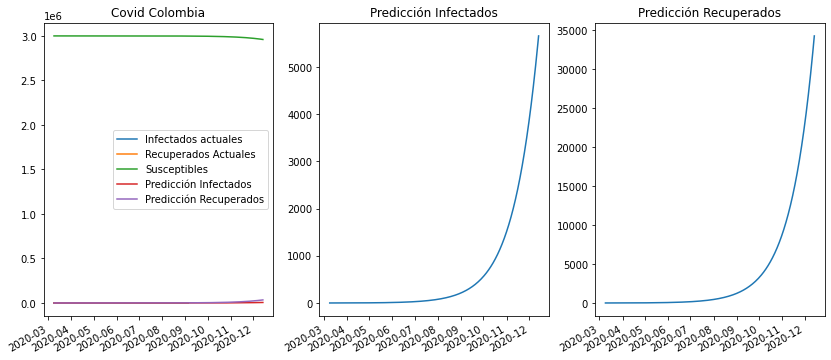

In [ ]:
s_0 = 3000000
i_0 = 1
r_0 = 0.7
pres_fut = np.array(list(data.index.values)+ list((np.array(pd.date_range('2020-09-06', periods=100))))) #  months from 5th May
train(recovered, infected, data)

**Largo Plazo - 1000 Días**

      fun: 210.82198929788538
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00998739, -0.00960654])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 81
      nit: 18
   status: 0
  success: True
        x: array([0.21940448, 0.18705767])
El intervalo de confianza es: (3831.125318780473, 3340.7791522081448, 4321.471485352802)
country=Colombia, beta=0.21940448, gamma=0.18705767, r_0:1.17292427


,Infectados actuales,Recuperados Actuales,Susceptibles,Predicción Infectados,Predicción Recuperados
2023-02-23,None,None,2.160787e+06,0.000178,839214.359245
2023-02-24,None,None,2.160787e+06,0.000173,839214.359277
2023-02-25,None,None,2.160787e+06,0.000168,839214.359309
2023-02-26,None,None,2.160787e+06,0.000163,839214.359339
2023-02-27,None,None,2.160787e+06,0.000159,839214.359369
...,...,...,...,...,...
2023-05-29,None,None,2.160787e+06,0.000011,839214.360317
2023-05-30,None,None,2.160787e+06,0.000011,839214.360319
2023-05-31,None,None,2.160787e+06,0.000011,839214.360321
2023-06-01,None,None,2.160787e+06,0.000011,839214.360322


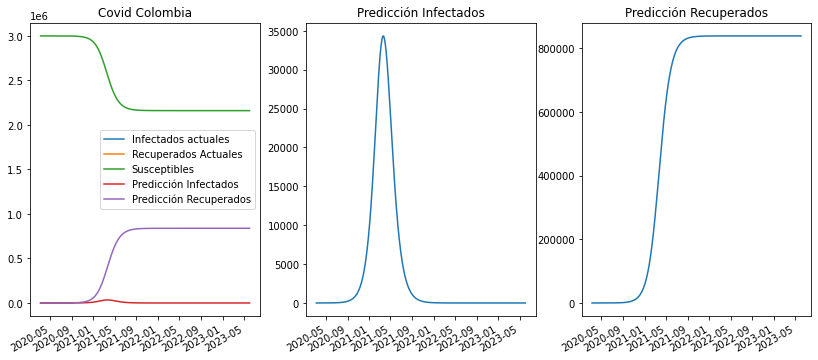

In [ ]:
s_0 = 3000000
i_0 = 1
r_0 = 0.7
pres_fut = np.array(list(data.index.values)+ list((np.array(pd.date_range('2020-09-06', periods=1000))))) #  months from 5th May
train(recovered, infected, data)

#### Medellín ARIMA

In [ ]:
#Actualizo el df temporal con la ciudad.
datos_arima_XX = datos_arima_MED.copy()
## Separo los valores entre train y test.
train_size = int(len(datos_arima_XX) * 0.85)
test_size = len(datos_arima_XX) - train_size
train_data, test_data = datos_arima_XX[0:train_size], datos_arima_XX[train_size:]

Train

In [ ]:
# ESTABLEZCO EL TAMAÑO ESTACIONAL QUE DE ACUERDO A LOS DATOS DE 'TEST' DISMINUYA EL ERROR ABSOLUTO PROMEDIO.
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
## Generar los parámetros del ARIMA, a partir del train data.
MAE = []
for x in range(15, 26):
  mod = sm.tsa.statespace.SARIMAX(train_data['Casos'],
                                  order=(1, 2, 2),
                                  seasonal_order=(1, 1, 1, x),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)

  results = mod.fit()

  ## Genero las predicciones.
  arima_pred = results.predict(start = len(train_data)+1, end = len(datos_arima_XX) , dynamic=False, typ="levels").rename("Pronostico")

  ## Genero la lista de dias para indexar el df 'arima_pred'.
  dateList = []
  dateList = [test_data.index[0] + datetime.timedelta(days = x) for x in range (0, len(arima_pred))]

  ## Convierto la serie en df y pongo la fecha como index
  arima_pred = pd.DataFrame(data=arima_pred, columns=['Pronostico'])
  arima_pred['fecha_reporte_web'] = dateList
  arima_pred = arima_pred.set_index(['fecha_reporte_web'])

  ## Creo df para comparar train y test.
  metric_df = arima_pred.join(datos_arima_XX['Casos'])
  metric_df.dropna(inplace=True)
  
  MAE.append([x, mean_absolute_error(metric_df.Casos, metric_df.Pronostico)])
minMAE = pd.DataFrame(MAE,columns=['Tamaño_estac','Error'])
E = minMAE['Tamaño_estac'].loc[minMAE['Error'].idxmin()]


In [ ]:
## Generar los parámetros del ARIMA, a partir del train data.
mod = sm.tsa.statespace.SARIMAX(train_data['Casos'],
                                order=(1, 2, 2),
                                seasonal_order=(1, 1, 1, E),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1937      0.062      3.149      0.002       0.073       0.314
ma.L1         -1.9532      1.596     -1.224      0.221      -5.080       1.174
ma.L2          0.9994      1.633      0.612      0.540      -2.201       4.200
ar.S.L15      -0.7475      0.248     -3.014      0.003      -1.234      -0.261
ma.S.L15      -0.4811      0.203     -2.374      0.018      -0.878      -0.084
sigma2      2.325e+04   3.81e+04      0.611      0.541   -5.13e+04    9.78e+04


 Test


In [ ]:
## Genero las predicciones.
arima_pred = results.predict(start = len(train_data)+1, end = len(datos_arima_XX) , dynamic=False, typ="levels").rename("Pronostico")

## Genero la lista de dias para indexar el df 'arima_pred'
dateList = []
dateList = [test_data.index[0] + datetime.timedelta(days = x) for x in range (0, len(arima_pred))]

## Convierto la serie en df y pongo la fecha como index
arima_pred = pd.DataFrame(data=arima_pred, columns=['Pronostico'])
arima_pred['fecha_reporte_web'] = dateList
#casos['fecha_reporte_web'] = pd.to_datetime(casos['fecha_reporte_web']) #Convertir a fecha
arima_pred = arima_pred.set_index(['fecha_reporte_web'])


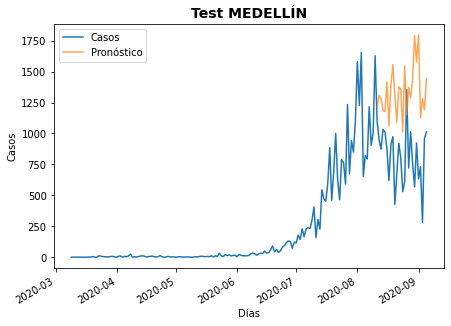

In [ ]:
ax = datos_arima_XX['2020':].plot(label='Reales',figsize=(7, 5))
arima_pred['Pronostico'].plot(ax=ax, label='Pronóstico', alpha=.7)

conf_int = 2 * arima_pred.std()

#plt.fill_between(conf_int.index, 
#                 arima_pred-conf_int, 
#                 arima_pred+conf_int, 
#                 color='b', alpha=.1)
ax.set_title('Test MEDELLÍN', fontsize = 14, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Días')
ax.set_ylabel('Casos')
plt.legend()

plt.show()

In [ ]:
## Creo df para comparar train y test.
metric_df = arima_pred.join(datos_arima_XX['Casos'])
metric_df.dropna(inplace=True)

In [ ]:
r2_score(metric_df['Casos'], metric_df["Pronostico"])

-6.069463113249137

In [ ]:
prophet_rmse_error = rmse(metric_df['Casos'], metric_df["Pronostico"])
prophet_mse_error = prophet_rmse_error**2

print(f'MSE Error: {prophet_mse_error}\nRMSE Error: {prophet_rmse_error}')

MSE Error: 371133.2601553507
RMSE Error: 609.2070749386868


In [ ]:
mean_absolute_error(metric_df.Casos, metric_df.Pronostico)

533.2209269229038

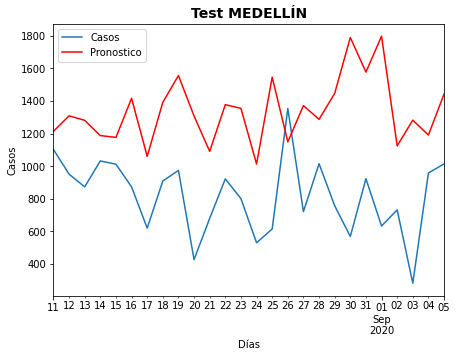

In [ ]:
ax=test_data.plot(legend=True, figsize=(7,5))
arima_pred.plot(ax=ax,legend = True, color='red')
ax.set_title('Test MEDELLÍN', fontsize = 14, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Días')
ax.set_ylabel('Casos')
plt.show()


Generalización

In [ ]:
last_day = 100    ##Cantidad de dias a predecir.

In [ ]:
## Genero las predicciones.
arima_pred_MED = results.predict(start = len(train_data)+1, end = len(train_data)+1+last_day , typ="levels").rename("Pronostico")

## Genero la lista de dias para indexar el df 'arima_pred'
dateList = []
dateList = [test_data.index[0] + datetime.timedelta(days = x) for x in range (0, len(arima_pred_MED))]

## Convierto la serie en df y pongo la fecha como index
arima_pred_MED = pd.DataFrame(data=arima_pred_MED, columns=['Pronostico'])
arima_pred_MED['fecha_reporte_web'] = dateList
arima_pred_MED = arima_pred_MED.set_index(['fecha_reporte_web'])


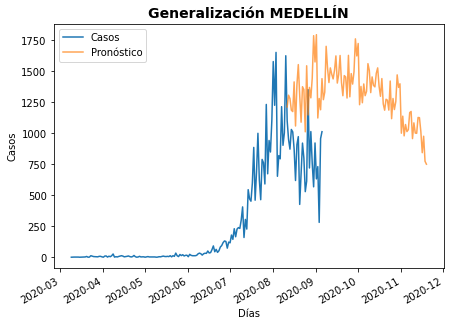

In [ ]:
ax = datos_arima_XX['2020':].plot(label='Reales',figsize=(7, 5))
arima_pred_MED['Pronostico'].plot(ax=ax, label='Pronóstico', alpha=.7)

#ax.fill_between(pred_ci.index,
#                pred_ci.iloc[:, 0],
#                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_title('Generalización MEDELLÍN', fontsize = 14, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Días')
ax.set_ylabel('Casos')
plt.legend()

plt.show()

###CALI

####Cali SIR

In [ ]:
casos_dia_SIR_CAL = casos_imp_SIR.copy()
casos_dia_SIR_CAL[casos_dia_SIR_CAL['Ciudad_de_ubicación'].isin(['Cali'])]
dfc=casos_dia_SIR_CAL.copy()
fc_reporte=pd.DataFrame()
fc_reporte['cantidad_reporte']=dfc.groupby('fecha_reporte_web').size()
fc_reporte['f_reporte']=fc_reporte.index
Df1c=dfc[dfc['atención'] == 'Fallecido']
fc_muerte=pd.DataFrame()
fc_muerte['cantidad_muertes']=Df1c.groupby('Fecha_de_muerte').size()
fc_muerte['f_muerte']=fc_muerte.index
Df2c=dfc[dfc['atención'] == 'Recuperado']
fc_recuperado=pd.DataFrame()
fc_recuperado['cantidad_recuperados']=Df2c.groupby('Fecha_recuperado').size()
fc_recuperado['f_recuperados']=fc_recuperado.index
cons1c=pd.merge(fc_reporte, fc_muerte, left_on='f_reporte', right_on='f_muerte', how='left')
consc=pd.merge(cons1c, fc_recuperado, left_on='f_reporte', right_on='f_recuperados', how='left')
cols1 = ['f_reporte', 'cantidad_reporte','cantidad_recuperados','cantidad_muertes']
df1c=consc[cols1]
df2c = df1c.fillna(0)
df3c=df2c.copy()
df3c['Activos']=abs(df3c['cantidad_reporte']-df3c['cantidad_recuperados']-df3c['cantidad_muertes'])
data = df3c.set_index('f_reporte')['Activos']
infected = df3c.set_index('f_reporte')['cantidad_reporte']
recovered = df3c.set_index('f_reporte')['cantidad_recuperados']


**Corto Plazo - 100 Días**

      fun: 1761.7662235340124
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.67324288e-01, -6.58737940e+02])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 207
      nit: 38
   status: 0
  success: True
        x: array([0.44158469, 0.4       ])
El intervalo de confianza es: (2819.081159889118, 2343.372893863784, 3294.7894259144523)
country=Colombia, beta=0.44158469, gamma=0.40000000, r_0:1.10396173


,Infectados actuales,Recuperados Actuales,Susceptibles,Predicción Infectados,Predicción Recuperados
2020-09-06,None,None,2.481163e+06,1708.959364,17129.652012
2020-09-07,None,None,2.480401e+06,1774.991936,17825.520181
2020-09-08,None,None,2.479610e+06,1843.399904,18548.548546
2020-09-09,None,None,2.478788e+06,1914.268202,19299.754039
2020-09-10,None,None,2.477934e+06,1987.677039,20080.166368
...,...,...,...,...,...
2020-12-10,None,None,2.190786e+06,10297.754220,298917.612991
2020-12-11,None,None,2.186832e+06,10160.833496,303009.365357
2020-12-12,None,None,2.182938e+06,10018.751436,307045.399766
2020-12-13,None,None,2.179106e+06,9871.896019,311023.716219


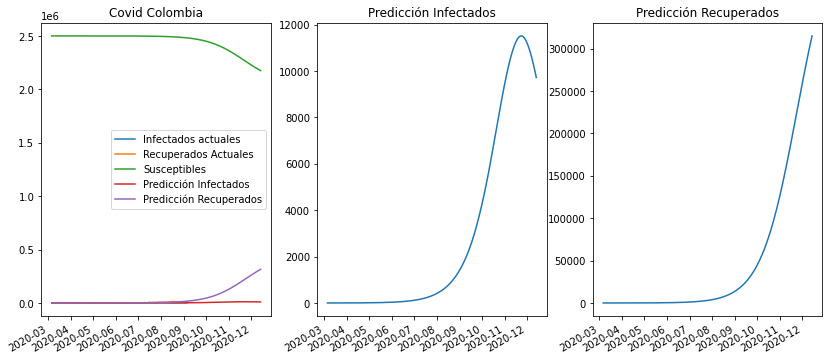

In [ ]:
s_0 = 2500000
i_0 = 1
r_0 = 0.76
pres_fut = np.array(list(data.index.values)+ list((np.array(pd.date_range('2020-09-06', periods=100))))) #  months from 5th May
train(recovered, infected, data)

**Largo Plazo - 1000 Días**

      fun: 1761.7662235340124
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.67324288e-01, -6.58737940e+02])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 207
      nit: 38
   status: 0
  success: True
        x: array([0.44158469, 0.4       ])
El intervalo de confianza es: (965.1158595671146, 819.921885106132, 1110.3098340280972)
country=Colombia, beta=0.44158469, gamma=0.40000000, r_0:1.10396173


,Infectados actuales,Recuperados Actuales,Susceptibles,Predicción Infectados,Predicción Recuperados
2023-02-23,None,None,2.044046e+06,-7.254510e-07,455955.661100
2023-02-24,None,None,2.044046e+06,-7.507918e-07,455955.661100
2023-02-25,None,None,2.044046e+06,-7.739018e-07,455955.661100
2023-02-26,None,None,2.044046e+06,-7.946979e-07,455955.661101
2023-02-27,None,None,2.044046e+06,-8.131040e-07,455955.661101
...,...,...,...,...,...
2023-05-29,None,None,2.044046e+06,3.877868e-07,455955.661089
2023-05-30,None,None,2.044046e+06,3.732747e-07,455955.661089
2023-05-31,None,None,2.044046e+06,3.592798e-07,455955.661089
2023-06-01,None,None,2.044046e+06,3.457662e-07,455955.661089


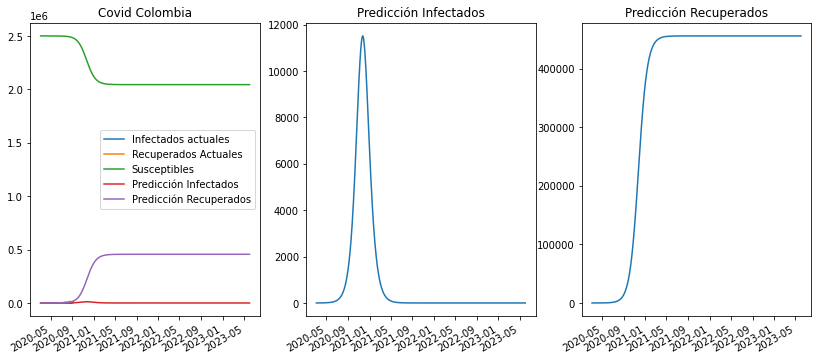

In [ ]:
s_0 = 2500000
i_0 = 1
r_0 = 0.76
pres_fut = np.array(list(data.index.values)+ list((np.array(pd.date_range('2020-09-06', periods=1000))))) #  months from 5th May
train(recovered, infected, data)

#### Cali ARIMA

In [ ]:
##Actualizo el df temporal con la ciudad.
datos_arima_XX = datos_arima_CAL.copy()
## Separo los valores entre train y test.
train_size = int(len(datos_arima_XX) * 0.80)
test_size = len(datos_arima_XX) - train_size
train_data, test_data = datos_arima_XX[0:train_size], datos_arima_XX[train_size:]

Train

In [ ]:
# ESTABLEZCO EL TAMAÑO ESTACIONAL QUE DE ACUERDO A LOS DATOS DE 'TEST' DISMINUYA EL ERROR ABSOLUTO PROMEDIO.
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
## Generar los parámetros del ARIMA, a partir del train data.
MAE = []
for x in range(15, 26):
  mod = sm.tsa.statespace.SARIMAX(train_data['Casos'],
                                  order=(1, 2, 2),
                                  seasonal_order=(1, 1, 1, x),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)

  results = mod.fit()

  ## Genero las predicciones.
  arima_pred = results.predict(start = len(train_data)+1, end = len(datos_arima_XX) , dynamic=False, typ="levels").rename("Pronostico")

  ## Genero la lista de dias para indexar el df 'arima_pred'.
  dateList = []
  dateList = [test_data.index[0] + datetime.timedelta(days = x) for x in range (0, len(arima_pred))]

  ## Convierto la serie en df y pongo la fecha como index
  arima_pred = pd.DataFrame(data=arima_pred, columns=['Pronostico'])
  arima_pred['fecha_reporte_web'] = dateList
  arima_pred = arima_pred.set_index(['fecha_reporte_web'])

  ## Creo df para comparar train y test.
  metric_df = arima_pred.join(datos_arima_XX['Casos'])
  metric_df.dropna(inplace=True)
  
  MAE.append([x, mean_absolute_error(metric_df.Casos, metric_df.Pronostico)])
minMAE = pd.DataFrame(MAE,columns=['Tamaño_estac','Error'])
E = minMAE['Tamaño_estac'].loc[minMAE['Error'].idxmin()]


In [ ]:
## Generar los parámetros del ARIMA, a partir del train data.
mod = sm.tsa.statespace.SARIMAX(train_data['Casos'],
                                order=(1, 2, 2),
                                seasonal_order=(1, 1, 1, E),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1864      0.093     -1.999      0.046      -0.369      -0.004
ma.L1         -2.0042      0.127    -15.797      0.000      -2.253      -1.756
ma.L2          0.9995      0.129      7.767      0.000       0.747       1.252
ar.S.L18      -0.8397      0.254     -3.311      0.001      -1.337      -0.343
ma.S.L18      -0.3812      0.311     -1.225      0.221      -0.991       0.229
sigma2      5850.8385   4.37e-05   1.34e+08      0.000    5850.838    5850.839


 Test


In [ ]:
## Genero las predicciones.
arima_pred = results.predict(start = len(train_data)+1, end = len(datos_arima_XX) , dynamic=False, typ="levels").rename("Pronostico")

## Genero la lista de dias para indexar el df 'arima_pred'
dateList = []
dateList = [test_data.index[0] + datetime.timedelta(days = x) for x in range (0, len(arima_pred))]

## Convierto la serie en df y pongo la fecha como index
arima_pred = pd.DataFrame(data=arima_pred, columns=['Pronostico'])
arima_pred['fecha_reporte_web'] = dateList
#casos['fecha_reporte_web'] = pd.to_datetime(casos['fecha_reporte_web']) #Convertir a fecha
arima_pred = arima_pred.set_index(['fecha_reporte_web'])


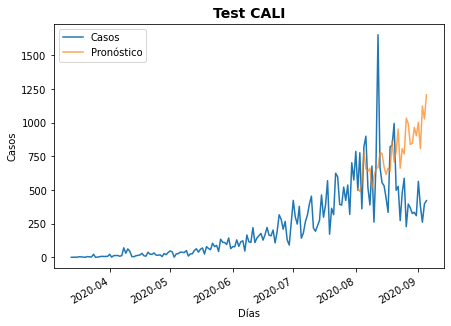

In [ ]:
ax = datos_arima_XX['2020':].plot(label='Reales',figsize=(7, 5))
arima_pred['Pronostico'].plot(ax=ax, label='Pronóstico', alpha=.7)

conf_int = 2 * arima_pred.std()

#plt.fill_between(conf_int.index, 
#                 arima_pred-conf_int, 
#                 arima_pred+conf_int, 
#                 color='b', alpha=.1)
ax.set_title('Test CALI', fontsize = 14, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Días')
ax.set_ylabel('Casos')
plt.legend()

plt.show()

In [ ]:
## Creo df para comparar train y test.
metric_df = arima_pred.join(datos_arima_XX['Casos'])
metric_df.dropna(inplace=True)


In [ ]:
r2_score(metric_df['Casos'], metric_df["Pronostico"])

-1.5360064111132488

In [ ]:
prophet_rmse_error = rmse(metric_df['Casos'], metric_df["Pronostico"])
prophet_mse_error = prophet_rmse_error**2

print(f'MSE Error: {prophet_mse_error}\nRMSE Error: {prophet_rmse_error}')

MSE Error: 189713.89883605036
RMSE Error: 435.5615901753165


In [ ]:
mean_absolute_error(metric_df.Casos, metric_df.Pronostico)

357.2305537978599

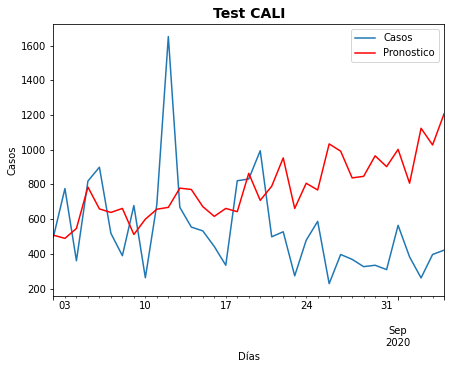

In [ ]:
ax=test_data.plot(legend=True, figsize=(7,5))
arima_pred.plot(ax=ax,legend = True, color='red')
ax.set_title('Test CALI', fontsize = 14, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Días')
ax.set_ylabel('Casos')
plt.show()


Generalización

In [ ]:
last_day = 90    ##Cantidad de dias a predecir.

In [ ]:
## Genero las predicciones.
arima_pred_CAL = results.predict(start = len(train_data)+1, end = len(train_data)+1+last_day , typ="levels").rename("Pronostico")

## Genero la lista de dias para indexar el df 'arima_pred'
dateList = []
dateList = [test_data.index[0] + datetime.timedelta(days = x) for x in range (0, len(arima_pred_CAL))]

## Convierto la serie en df y pongo la fecha como index
arima_pred_CAL = pd.DataFrame(data=arima_pred_CAL, columns=['Pronostico'])
arima_pred_CAL['fecha_reporte_web'] = dateList
arima_pred_CAL = arima_pred_CAL.set_index(['fecha_reporte_web'])


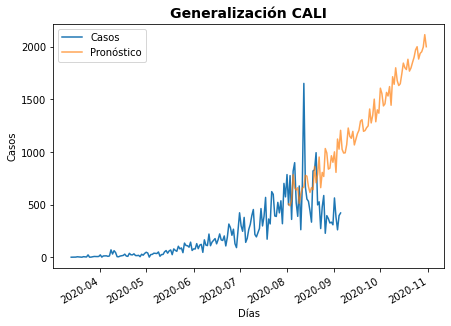

In [ ]:
ax = datos_arima_XX['2020':].plot(label='Reales',figsize=(7, 5))
arima_pred_CAL['Pronostico'].plot(ax=ax, label='Pronóstico', alpha=.7)

#ax.fill_between(pred_ci.index,
#                pred_ci.iloc[:, 0],
#                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_title('Generalización CALI', fontsize = 14, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Días')
ax.set_ylabel('Casos')
plt.legend()

plt.show()

###BARRANQUILLA

####Barranquilla SIR

In [ ]:
casos_dia_SIR_BAQ = casos_imp_SIR.copy()
casos_dia_SIR_BAQ[casos_dia_SIR_BAQ['Ciudad_de_ubicación'].isin(['Barranquilla'])]
dfb=casos_dia_SIR_BAQ.copy()
f_reporteb=pd.DataFrame()
f_reporteb['cantidad_reporte']=dfb.groupby('fecha_reporte_web').size()
f_reporteb['f_reporte']=f_reporteb.index
Df1b=dfb[dfb['atención'] == 'Fallecido']
f_muerteb=pd.DataFrame()
f_muerteb['cantidad_muertes']=Df1b.groupby('Fecha_de_muerte').size()
f_muerteb['f_muerte']=f_muerteb.index
Df2b=dfb[dfb['atención'] == 'Recuperado']
f_recuperadob=pd.DataFrame()
f_recuperadob['cantidad_recuperados']=Df2b.groupby('Fecha_recuperado').size()
f_recuperadob['f_recuperados']=f_recuperadob.index
cons1b=pd.merge(f_reporteb, f_muerteb, left_on='f_reporte', right_on='f_muerte', how='left')
consb=pd.merge(cons1b, f_recuperadob, left_on='f_reporte', right_on='f_recuperados', how='left')
cols1 = ['f_reporte', 'cantidad_reporte','cantidad_recuperados','cantidad_muertes']
df1b=consb[cols1]
df2b = df1b.fillna(0)
df3b=df2b.copy()
df3b['Activos']=abs(df3b['cantidad_reporte']-df3b['cantidad_recuperados']-df3b['cantidad_muertes'])
data = df3b.set_index('f_reporte')['Activos']
infected = df3b.set_index('f_reporte')['cantidad_reporte']
recovered = df3b.set_index('f_reporte')['cantidad_recuperados']


**Corto Plazo - 100 Días**

      fun: 1732.9244050399943
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 3.12866177e-01, -7.17149464e+02])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 114
      nit: 17
   status: 0
  success: True
        x: array([0.44183113, 0.4       ])
El intervalo de confianza es: (1621.1185680853305, 1383.3219493259696, 1858.9151868446913)
country=Colombia, beta=0.44183113, gamma=0.40000000, r_0:1.10457783


,Infectados actuales,Recuperados Actuales,Susceptibles,Predicción Infectados,Predicción Recuperados
2020-09-06,None,None,1.181349e+06,1633.180614,17019.935353
2020-09-07,None,None,1.180628e+06,1690.503127,17682.975434
2020-09-08,None,None,1.179883e+06,1749.439765,18369.764524
2020-09-09,None,None,1.179111e+06,1810.019474,19081.041636
2020-09-10,None,None,1.178312e+06,1872.263713,19817.522003
...,...,...,...,...,...
2020-12-10,None,None,1.020217e+06,3462.624826,176322.584430
2020-12-11,None,None,1.018933e+06,3377.381608,177691.364999
2020-12-12,None,None,1.017683e+06,3292.862448,179026.048562
2020-12-13,None,None,1.016466e+06,3209.246167,180326.902890


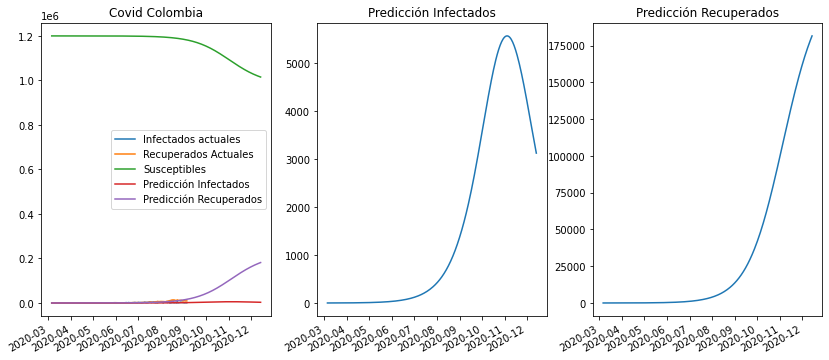

In [ ]:
s_0 = 1200000
i_0 = 1
r_0 = 0.76
pres_fut = np.array(list(data.index.values)+ list((np.array(pd.date_range('2020-09-06', periods=100))))) #  months from 5th May
train(recovered, infected, data)

**Largo Plazo - 1000 Días**

      fun: 1732.9244050399943
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 3.12866177e-01, -7.17149464e+02])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 114
      nit: 17
   status: 0
  success: True
        x: array([0.44183113, 0.4       ])
El intervalo de confianza es: (465.43084824978155, 395.20139668004924, 535.6602998195139)
country=Colombia, beta=0.44183113, gamma=0.40000000, r_0:1.10457783


,Infectados actuales,Recuperados Actuales,Susceptibles,Predicción Infectados,Predicción Recuperados
2023-02-23,None,None,980122.244195,1.082024e-06,219879.515804
2023-02-24,None,None,980122.244196,1.160016e-06,219879.515803
2023-02-25,None,None,980122.244197,1.235638e-06,219879.515802
2023-02-26,None,None,980122.244197,1.308582e-06,219879.515801
2023-02-27,None,None,980122.244198,1.378533e-06,219879.515800
...,...,...,...,...,...
2023-05-29,None,None,980122.244195,1.009639e-06,219879.515804
2023-05-30,None,None,980122.244195,1.013235e-06,219879.515804
2023-05-31,None,None,980122.244195,1.008945e-06,219879.515804
2023-06-01,None,None,980122.244195,9.961445e-07,219879.515804


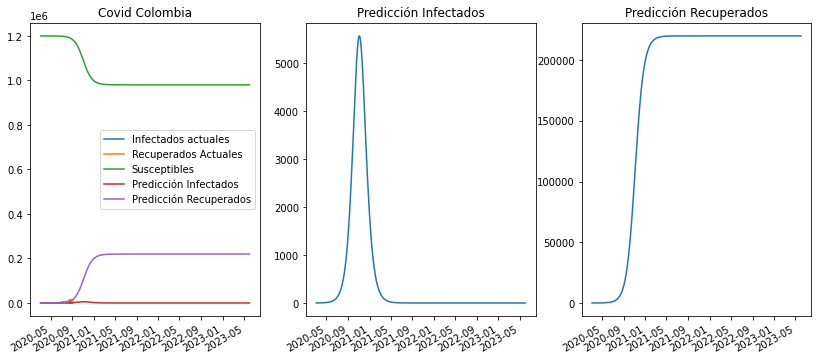

In [ ]:
s_0 = 1200000
i_0 = 1
r_0 = 0.76
pres_fut = np.array(list(data.index.values)+ list((np.array(pd.date_range('2020-09-06', periods=1000))))) #  months from 5th May
train(recovered, infected, data)

#### Barranquilla ARIMA

In [ ]:
#Actualizo el df temporal con la ciudad.
datos_arima_XX = datos_arima_BAQ.copy()
## Separo los valores entre train y test.
train_size = int(len(datos_arima_XX) * 0.65)
test_size = len(datos_arima_XX) - train_size
train_data, test_data = datos_arima_XX[0:train_size], datos_arima_XX[train_size:]

Train

In [ ]:
# ESTABLEZCO EL TAMAÑO ESTACIONAL QUE DE ACUERDO A LOS DATOS DE 'TEST' DISMINUYA EL ERROR ABSOLUTO PROMEDIO.
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
## Generar los parámetros del ARIMA, a partir del train data.
MAE = []
for x in range(15, 26):
  mod = sm.tsa.statespace.SARIMAX(train_data['Casos'],
                                  order=(1, 2, 2),
                                  seasonal_order=(1, 2, 1, x),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)

  results = mod.fit()

  ## Genero las predicciones.
  arima_pred = results.predict(start = len(train_data)+1, end = len(datos_arima_XX) , dynamic=False, typ="levels").rename("Pronostico")

  ## Genero la lista de dias para indexar el df 'arima_pred'.
  dateList = []
  dateList = [test_data.index[0] + datetime.timedelta(days = x) for x in range (0, len(arima_pred))]

  ## Convierto la serie en df y pongo la fecha como index
  arima_pred = pd.DataFrame(data=arima_pred, columns=['Pronostico'])
  arima_pred['fecha_reporte_web'] = dateList
  arima_pred = arima_pred.set_index(['fecha_reporte_web'])

  ## Creo df para comparar train y test.
  metric_df = arima_pred.join(datos_arima_XX['Casos'])
  metric_df.dropna(inplace=True)
  
  MAE.append([x, mean_absolute_error(metric_df.Casos, metric_df.Pronostico)])
minMAE = pd.DataFrame(MAE,columns=['Tamaño_estac','Error'])
E = minMAE['Tamaño_estac'].loc[minMAE['Error'].idxmin()]


In [ ]:
## Generar los parámetros del ARIMA, a partir del train data.
mod = sm.tsa.statespace.SARIMAX(train_data['Casos'],
                                order=(1, 1, 2),
                                seasonal_order=(1, 1, 1, E),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4142         -0        inf      0.000      -0.414      -0.414
ma.L1         -0.6883         -0        inf      0.000      -0.688      -0.688
ma.L2          0.1979   2.05e-32   9.67e+30      0.000       0.198       0.198
ar.S.L23      -2.1326   1.24e-32  -1.72e+32      0.000      -2.133      -2.133
ma.S.L23    2.821e+14    1.7e-33   1.66e+47      0.000    2.82e+14    2.82e+14
sigma2      3.791e-12   2.52e-10      0.015      0.988    -4.9e-10    4.97e-10


 Test


In [ ]:
## Genero las predicciones.
arima_pred = results.predict(start = len(train_data)+1, end = len(datos_arima_XX) , dynamic=False, typ="levels").rename("Pronostico")

## Genero la lista de dias para indexar el df 'arima_pred'
dateList = []
dateList = [test_data.index[0] + datetime.timedelta(days = x) for x in range (0, len(arima_pred))]

## Convierto la serie en df y pongo la fecha como index
arima_pred = pd.DataFrame(data=arima_pred, columns=['Pronostico'])
arima_pred['fecha_reporte_web'] = dateList
#casos['fecha_reporte_web'] = pd.to_datetime(casos['fecha_reporte_web']) #Convertir a fecha
arima_pred = arima_pred.set_index(['fecha_reporte_web'])


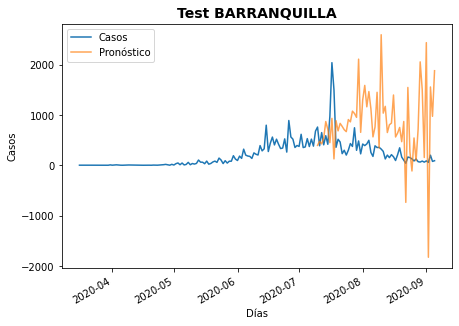

In [ ]:
ax = datos_arima_XX['2020':].plot(label='Reales',figsize=(7, 5))
arima_pred['Pronostico'].plot(ax=ax, label='Pronóstico', alpha=.7)

conf_int = 2 * arima_pred.std()

#plt.fill_between(conf_int.index, 
#                 arima_pred-conf_int, 
#                 arima_pred+conf_int, 
#                 color='b', alpha=.1)
ax.set_title('Test BARRANQUILLA', fontsize = 14, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Días')
ax.set_ylabel('Casos')
plt.legend()

plt.show()

In [ ]:
## Creo df para comparar train y test.
metric_df = arima_pred.join(datos_arima_XX['Casos'])
metric_df.dropna(inplace=True)


In [ ]:
r2_score(metric_df['Casos'], metric_df["Pronostico"])

-6.61474374040314

In [ ]:
prophet_rmse_error = rmse(metric_df['Casos'], metric_df["Pronostico"])
prophet_mse_error = prophet_rmse_error**2

print(f'MSE Error: {prophet_mse_error}\nRMSE Error: {prophet_rmse_error}')

MSE Error: 858724.1496625554
RMSE Error: 926.6737018295897


In [ ]:
mean_absolute_error(metric_df.Casos, metric_df.Pronostico)

740.0495382243059

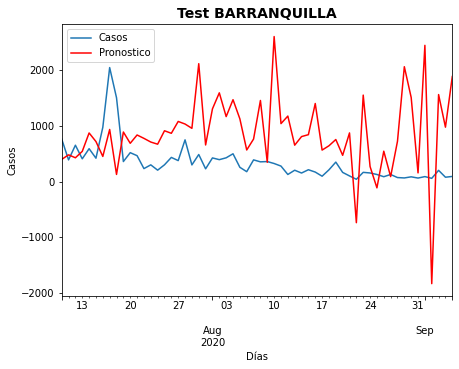

In [ ]:
ax=test_data.plot(legend=True, figsize=(7,5))
arima_pred.plot(ax=ax,legend = True, color='red')
ax.set_title('Test BARRANQUILLA', fontsize = 14, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Días')
ax.set_ylabel('Casos')
plt.show()


Generalización

In [ ]:
last_day = 150    ##Cantidad de dias a predecir.

In [ ]:
## Genero las predicciones.
arima_pred_BAQ = results.predict(start = len(train_data)+1, end = len(train_data)+1+last_day , typ="levels").rename("Pronostico")

## Genero la lista de dias para indexar el df 'arima_pred'
dateList = []
dateList = [test_data.index[0] + datetime.timedelta(days = x) for x in range (0, len(arima_pred_BAQ))]

## Convierto la serie en df y pongo la fecha como index
arima_pred_BAQ = pd.DataFrame(data=arima_pred_BAQ, columns=['Pronostico'])
arima_pred_BAQ['fecha_reporte_web'] = dateList
arima_pred_BAQ = arima_pred_BAQ.set_index(['fecha_reporte_web'])


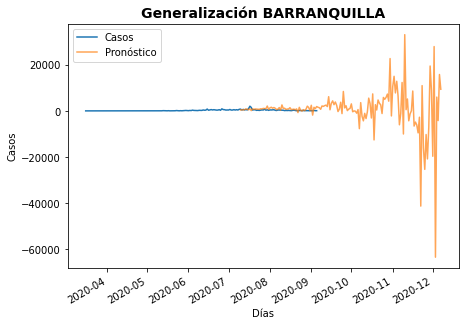

In [ ]:
ax = datos_arima_XX['2020':].plot(label='Reales',figsize=(7, 5))
arima_pred_BAQ['Pronostico'].plot(ax=ax, label='Pronóstico', alpha=.7)

#ax.fill_between(pred_ci.index,
#                pred_ci.iloc[:, 0],
#                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_title('Generalización BARRANQUILLA', fontsize = 14, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Días')
ax.set_ylabel('Casos')
plt.legend()

plt.show()

###CARTAGENA

#### Cartagena de Indias SIR

In [ ]:
casos_dia_SIR_CAR = casos_imp_SIR.copy()
casos_dia_SIR_CAR= casos_dia_SIR_CAR[casos_dia_SIR_CAR['Ciudad_de_ubicación'].isin(['Cartagena de Indias'])]
dfcar=casos_dia_SIR_CAR.copy()
f_reportecar=pd.DataFrame()
f_reportecar['cantidad_reporte']=dfcar.groupby('fecha_reporte_web').size()
f_reportecar['f_reporte']=f_reportecar.index
Df1car=dfcar[dfcar['atención'] == 'Fallecido']
f_muertecar=pd.DataFrame()
f_muertecar['cantidad_muertes']=Df1car.groupby('Fecha_de_muerte').size()
f_muertecar['f_muerte']=f_muertecar.index
Df2car=dfcar[dfcar['atención'] == 'Recuperado']
f_recuperadocar=pd.DataFrame()
f_recuperadocar['cantidad_recuperados']=Df2car.groupby('Fecha_recuperado').size()
f_recuperadocar['f_recuperados']=f_recuperadocar.index
cons1car=pd.merge(f_reportecar, f_muertecar, left_on='f_reporte', right_on='f_muerte', how='left')
conscar=pd.merge(cons1car, f_recuperadocar, left_on='f_reporte', right_on='f_recuperados', how='left')
cols1 = ['f_reporte', 'cantidad_reporte','cantidad_recuperados','cantidad_muertes']
df1car=cons[cols1]
df2car = df1car.fillna(0)
df3car=df2car.copy()
df3car['Activos']=abs(df3car['cantidad_reporte']-df3car['cantidad_recuperados']-df3car['cantidad_muertes'])
data = df3car.set_index('f_reporte')['Activos']
infected = df3car.set_index('f_reporte')['cantidad_reporte']
recovered = df3car.set_index('f_reporte')['cantidad_recuperados']

**Corto Plazo - 100 Días**

      fun: 1715.119798006008
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-6.98946678e-02, -7.52791379e+02])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 96
      nit: 18
   status: 0
  success: True
        x: array([0.44198402, 0.4       ])
El intervalo de confianza es: (1291.4168374786113, 1110.498397278304, 1472.3352776789186)
country=Colombia, beta=0.44198402, gamma=0.40000000, r_0:1.10496005


,Infectados actuales,Recuperados Actuales,Susceptibles,Predicción Infectados,Predicción Recuperados
2020-09-06,None,None,891459.943861,1588.512748,16953.303391
2020-09-07,None,None,890763.582285,1641.036765,17597.140950
2020-09-08,None,None,890044.320930,1694.756300,18262.682770
2020-09-09,None,None,889301.592202,1749.668674,18950.499125
2020-09-10,None,None,888534.868271,1805.764817,19661.126912
...,...,...,...,...,...
2020-12-10,None,None,766349.146814,2177.753058,141474.860128
2020-12-11,None,None,765550.059809,2116.937392,142334.762799
2020-12-12,None,None,764774.297848,2057.183844,143170.278308
2020-12-13,None,None,764021.371454,1998.580402,143981.808143


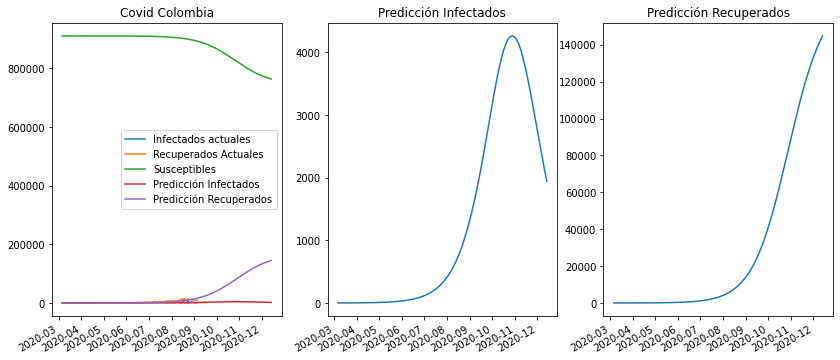

In [ ]:
s_0 = 910000
i_0 = 1
r_0 = 0.76
pres_fut = np.array(list(data.index.values)+ list((np.array(pd.date_range('2020-09-06', periods=100))))) #  months from 5th May
train(recovered, infected, data)

**Largo Plazo - 1000 Días**

      fun: 1715.119798006008
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-6.98946678e-02, -7.52791379e+02])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 96
      nit: 18
   status: 0
  success: True
        x: array([0.44198402, 0.4       ])
El intervalo de confianza es: (354.31910738991564, 300.7041494026376, 407.9340653771937)
country=Colombia, beta=0.44198402, gamma=0.40000000, r_0:1.10496005


,Infectados actuales,Recuperados Actuales,Susceptibles,Predicción Infectados,Predicción Recuperados
2023-02-23,None,None,742622.661568,6.678754e-07,167379.098432
2023-02-24,None,None,742622.661568,7.196903e-07,167379.098431
2023-02-25,None,None,742622.661568,7.695094e-07,167379.098431
2023-02-26,None,None,742622.661569,8.170521e-07,167379.098430
2023-02-27,None,None,742622.661569,8.620299e-07,167379.098430
...,...,...,...,...,...
2023-05-29,None,None,742622.661569,8.453972e-07,167379.098430
2023-05-30,None,None,742622.661569,8.469660e-07,167379.098430
2023-05-31,None,None,742622.661569,8.421596e-07,167379.098430
2023-06-01,None,None,742622.661569,8.305108e-07,167379.098430


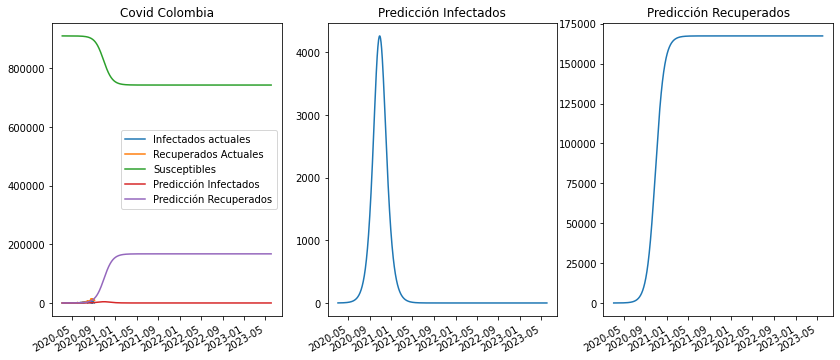

In [ ]:
s_0 = 910000
i_0 = 1
r_0 = 0.76
pres_fut = np.array(list(data.index.values)+ list((np.array(pd.date_range('2020-09-06', periods=1000))))) #  months from 5th May
train(recovered, infected, data)

#### Cartagena ARIMA

In [ ]:
#Actualizo el df temporal con la ciudad.
datos_arima_XX = datos_arima_CAR.copy()
## Separo los valores entre train y test.
train_size = int(len(datos_arima_XX) * 0.65)
test_size = len(datos_arima_XX) - train_size
train_data, test_data = datos_arima_XX[0:train_size], datos_arima_XX[train_size:]

Train

In [ ]:
# ESTABLEZCO EL TAMAÑO ESTACIONAL QUE DE ACUERDO A LOS DATOS DE 'TEST' DISMINUYA EL ERROR ABSOLUTO PROMEDIO.
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
## Generar los parámetros del ARIMA, a partir del train data.
MAE = []
for x in range(15, 26):
  mod = sm.tsa.statespace.SARIMAX(train_data['Casos'],
                                  order=(1, 2, 2),
                                  seasonal_order=(1, 1, 1, x),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)

  results = mod.fit()

  ## Genero las predicciones.
  arima_pred = results.predict(start = len(train_data)+1, end = len(datos_arima_XX) , dynamic=False, typ="levels").rename("Pronostico")

  ## Genero la lista de dias para indexar el df 'arima_pred'.
  dateList = []
  dateList = [test_data.index[0] + datetime.timedelta(days = x) for x in range (0, len(arima_pred))]

  ## Convierto la serie en df y pongo la fecha como index
  arima_pred = pd.DataFrame(data=arima_pred, columns=['Pronostico'])
  arima_pred['fecha_reporte_web'] = dateList
  arima_pred = arima_pred.set_index(['fecha_reporte_web'])

  ## Creo df para comparar train y test.
  metric_df = arima_pred.join(datos_arima_XX['Casos'])
  metric_df.dropna(inplace=True)
  
  MAE.append([x, mean_absolute_error(metric_df.Casos, metric_df.Pronostico)])
minMAE = pd.DataFrame(MAE,columns=['Tamaño_estac','Error'])
E = minMAE['Tamaño_estac'].loc[minMAE['Error'].idxmin()]


In [ ]:
## Generar los parámetros del ARIMA, a partir del train data.
mod = sm.tsa.statespace.SARIMAX(train_data['Casos'],
                                order=(1, 2, 2),
                                seasonal_order=(1, 1, 1, E),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1739      0.349     -0.499      0.618      -0.857       0.510
ma.L1         -1.4401      0.670     -2.150      0.032      -2.753      -0.127
ma.L2          0.4196      0.504      0.832      0.406      -0.569       1.408
ar.S.L17       0.0101      0.085      0.119      0.905      -0.156       0.176
ma.S.L17      -0.8653      0.542     -1.598      0.110      -1.927       0.196
sigma2      3699.8372   2289.520      1.616      0.106    -787.540    8187.214


 Test


In [ ]:
## Genero las predicciones.
arima_pred = results.predict(start = len(train_data)+1, end = len(datos_arima_XX) , dynamic=False, typ="levels").rename("Pronostico")

## Genero la lista de dias para indexar el df 'arima_pred'
dateList = []
dateList = [test_data.index[0] + datetime.timedelta(days = x) for x in range (0, len(arima_pred))]

## Convierto la serie en df y pongo la fecha como index
arima_pred = pd.DataFrame(data=arima_pred, columns=['Pronostico'])
arima_pred['fecha_reporte_web'] = dateList
#casos['fecha_reporte_web'] = pd.to_datetime(casos['fecha_reporte_web']) #Convertir a fecha
arima_pred = arima_pred.set_index(['fecha_reporte_web'])


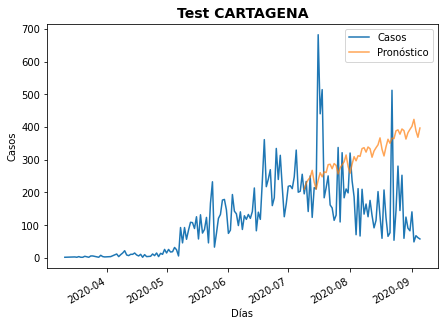

In [ ]:
ax = datos_arima_XX['2020':].plot(label='Reales',figsize=(7, 5))
arima_pred['Pronostico'].plot(ax=ax, label='Pronóstico', alpha=.7)

conf_int = 2 * arima_pred.std()

#plt.fill_between(conf_int.index, 
#                 arima_pred-conf_int, 
#                 arima_pred+conf_int, 
#                 color='b', alpha=.1)
ax.set_title('Test CARTAGENA', fontsize = 14, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Días')
ax.set_ylabel('Casos')
plt.legend()

plt.show()

In [ ]:
## Creo df para comparar train y test.
metric_df = arima_pred.join(datos_arima_XX['Casos'])
metric_df.dropna(inplace=True)


In [ ]:
r2_score(metric_df['Casos'], metric_df["Pronostico"])

-1.800801314625755

In [ ]:
prophet_rmse_error = rmse(metric_df['Casos'], metric_df["Pronostico"])
prophet_mse_error = prophet_rmse_error**2

print(f'MSE Error: {prophet_mse_error}\nRMSE Error: {prophet_rmse_error}')

MSE Error: 41168.65748957752
RMSE Error: 202.90060987975744


In [ ]:
mean_absolute_error(metric_df.Casos, metric_df.Pronostico)

174.4899748455987

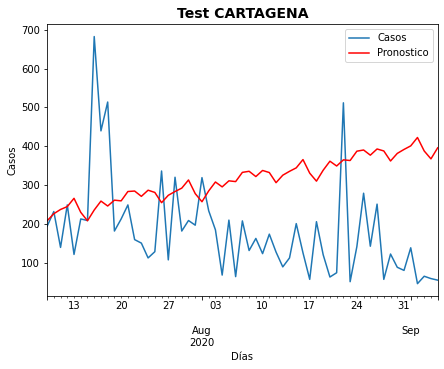

In [ ]:
ax=test_data.plot(legend=True, figsize=(7,5))
arima_pred.plot(ax=ax,legend = True, color='red')
ax.set_title('Test CARTAGENA', fontsize = 14, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Días')
ax.set_ylabel('Casos')
plt.show()


Generalización

In [ ]:
last_day = 90    ##Cantidad de dias a predecir.

In [ ]:
## Genero las predicciones.
arima_pred_CAR = results.predict(start = len(train_data)+1, end = len(train_data)+1+last_day , typ="levels").rename("Pronostico")

## Genero la lista de dias para indexar el df 'arima_pred'
dateList = []
dateList = [test_data.index[0] + datetime.timedelta(days = x) for x in range (0, len(arima_pred_CAR))]

## Convierto la serie en df y pongo la fecha como index
arima_pred_CAR = pd.DataFrame(data=arima_pred_CAR, columns=['Pronostico'])
arima_pred_CAR['fecha_reporte_web'] = dateList
arima_pred_CAR = arima_pred_CAR.set_index(['fecha_reporte_web'])


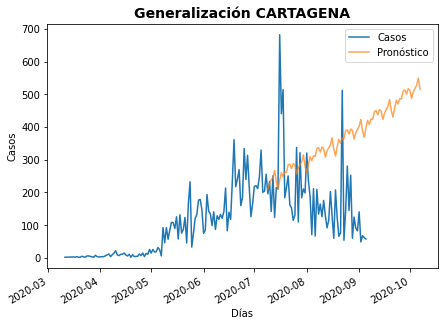

In [ ]:
ax = datos_arima_XX['2020':].plot(label='Reales',figsize=(7, 5))
arima_pred_CAR['Pronostico'].plot(ax=ax, label='Pronóstico', alpha=.7)

#ax.fill_between(pred_ci.index,
#                pred_ci.iloc[:, 0],
#                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_title('Generalización CARTAGENA', fontsize = 14, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Días')
ax.set_ylabel('Casos')
plt.legend()

plt.show()

***


#**Conclusiones Finales**

1. Durante la limpieza de los datos se identificaron muchas inconsistencias en estos (Valores null "Fechas, Estados del paciente"), pero por cuestiones de tiempo y desconocimiento en el proceso de recolección de estos fue necesario realizar muchas suposiciones que se entiende no fueron las más acertadas para el modelo.

2. El modelo SIR planteado presenta muchas oportunidades de mejora para futuros 
escenarios ya que como se mencionó anteriormente para este caso no se tuvo presente situaciones como la cuarentena estricta o que una misma persona puede contraer el virus más de una vez, pero a pesar de esto es importante resaltar que al comparar los datos reales de COVID que se han venido presentando hasta la fecha el modelo se comporta muy similar para los pròximos 20-30 días,sin embargo quedan abiertas inquietudes respecto al 2021 ya que el SIR indica que todos los picos van a darse en este periodo, pero según lo que hemos venido viviendo se espera que ocurra lo contrario.

3. Para los escenarios “Nacional”, “Bogotá”, “Cali” y "Cartagena", el modelo ARIMA proporciona una predicción del comportamiento del COVID-19 con una tendencia lineal creciente, en respuesta a los datos que sirvieron de muestra para el entrenamiento.

4. Para el caso de Medellín, el modelo logra interpretar una tendencia decremental del comportamiento de los casos de infectados, pero sin desestimar la posibilidad de un repunte de casos, situación que no sucede en modelos estándar como el SIR.

5. Es de esperarse que con las nuevas observaciones que ingresen al dataset en los próximos días, se logre una mayor claridad en la tendencia del comportamiento de los datos, y se logre una predicción mas exacta del comportamiento esperado.

6. Debido al comportamiento de los datos de entrenamiento, el modelo ARIMA tiene una baja capacidad de predicción para la ciudad de barranquilla, presentándose una alta fluctuación de los datos debido a que la estructura autorregresiva del modelo, no permite una buena tasa de aprendizaje, y dada la tendencia decreciente de los datos más recientes con los que contó la muestra de entrenamiento, se llega en algunos casos a predecir valores negativos, los cuales no son posibles en el contexto real del caso de estudio.





**Referencias**

* *Delia Ortega-Lenis, David Arango-Londoño, Edgar Muñoz, Daniel E. Cuartas, Diana Caicedo, Jorge Mena, Miyerlandi Torres y Fabian Mendez, Predicciones de un modelo SEIR para casos de COVID-19 en Cali, Colombia.*

* *PRECISIÓN DEL PRONÓSTICO DE LA PROPAGACIÓN DEL COVID-19 EN COLOMBIA, Díaz-Pinzón-Jorge Enrique. Revista Repertorio de Medicina y Cirugía.*

* *Fred G. Manrique-Abril, Carlos A. Agudelo-Calderon, Víctor M. González-Chordá, Oscar Gutiérrez-Lesmes, Cristian F. Téllez-Piñerez, Giomar Herrera-Amaya. Modelo SIR de la pandemia de Covid-19 en Colombia. Rev. salud pública, Volumen 22, Número 2, p. 1-9, 2020*

* *Catano-Lopez, Alexandra; Rojas-Diaz, Daniel. Modelos discretos de transmisión de COVID-19 y publicaciones preliminares en la ciencia: una búsqueda sistematizada. Escuela de ciencias, Universidad Eafit, Medellín, Colombia*

* *Sarkar, Dibash; Biswas, Moinak. COVID 19 Pandemic: A Real-time Forecasts & Prediction of Confirmed Cases, Active Cases using the ARIMA model & Public Health in West Bengal, India.https://www.medrxiv.org/content/10.1101/2020.06.06.20124180v1*

* *Balabdaoui, Fadoua;Mohr, Dirk. Age-stratified model of the COVID-19 epidemic to analyze the impact of relaxing lockdown measures: nowcasting and forecasting for Switzerland. https://www.medrxiv.org/content/10.1101/2020.05.08.20095059v2*


* *COVID-19 data with SIR model* https://www.kaggle.com/lisphilar/covid-19-data-with-sir-model/notebook

* *Henri Froese,Infectious Disease Modelling: Beyond the Basic SIR Model*,https://towardsdatascience.com/infectious-disease-modelling-beyond-the-basic-sir-model-216369c584c4

* *Fred G. Manrique-Abril, Carlos A. Agudelo-Calderon,
Víctor M. González-Chordá, Oscar Gutiérrez-Lesmes,
Cristian F. Téllez-Piñerez y Giomar Herrera-Amaya. Modelo SIR de la pandemia
de Covid-19 en Colombia* . http://www.scielo.org.co/pdf/rsap/v22n1/0124-0064-rsap-22-01-e185977.pdf


